In [1]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%load_ext autoreload
%autoreload 1

Author: Andrew Tarzia

Date Created: 05 Aug 2018

Distributed under the terms of the MIT License.

# Notebook to analyse all enzymes used in ZIF-8 experiments using BRENDA database

TODO:
- add license
- modifications
    - introduce exposure consideration
        - get another method for calculating exposure without structure?
    - generalise code to multiple target residues ("targ = convert_to_one_letter_code_sing('target_res')" needs to act on a list

In [2]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Alphabet import IUPAC
from rdkit.Chem.Draw import IPythonConsole  # to show molecules in notebook
import time
import numpy as np
import pandas as pd
# ensure cpickle usage
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors3D import NPR1, NPR2, PMI1, PMI2, PMI3
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Geometry import rdGeometry
from rdkit.Chem import PyMol
from rdkit import Geometry
import tempfile
%aimport pi_fn
%aimport parameters
%aimport brenda_IO
%aimport SABIO_IO
%aimport rdkit_functions
%aimport ellipsoid
%aimport DB_functions
%aimport CHEBI_IO
%aimport BKMS_IO
%aimport KEGG_IO
%aimport Uniprot_IO
%aimport rxn_syst

# Calculate pI of all sequences in EC No. used in literature
## Produces distribution for each EC No.

## Notes:
### Biopython:
- pK values and the methods are taken from::
    * Bjellqvist, B.,Hughes, G.J., Pasquali, Ch., Paquet, N., Ravier, F.,
    Sanchez, J.-Ch., Frutiger, S. & Hochstrasser, D.F.
    The focusing positions of polypeptides in immobilized pH gradients can be
    predicted from their amino acid sequences. Electrophoresis 1993, 14,
    1023-1031.
    * Bjellqvist, B., Basse, B., Olsen, E. and Celis, J.E.
    Reference points for comparisons of two-dimensional maps of proteins from
    different human cell types defined in a pH scale where isoelectric points
    correlate with polypeptide compositions. Electrophoresis 1994, 15, 529-539.

|  AA | pKa  |
|-----|------|
| ASP | 4.05 |
| GLU | 4.45 |
| HIS | 5.98 |
| CYS | 9.00 |
| TYR | 10.0 |
| LYS | 10.0 |
| ARG | 12.0 |
| N-terminus | 7.50 |
| N-terminus : GLU | 7.7 |
| N-terminus : VAL | 7.44 |
| N-terminus : THR | 6.82 |
| N-terminus : PRO | 8.36 |
| N-terminus : SER | 6.93 |
| N-terminus : MET | 7.00 |
| N-terminus : ALA | 7.59 |
| C-terminus | 3.55 |
| C-terminus : ASP | 4.55 |
| C-terminus : GLU | 4.75 |

- with the above pKas and the data set in Tash's paper (DOI:) we apply a pI cut off = XX.


### Modified pIs:
- assuming sequence only and therefore cannot use DSSP to calculate exposure

In [3]:
# get parameters
param_dict = parameters.get_parameters()

# input parameters
database_directory = '/home/atarzia/psp/sequence_db/bio_min_dataset/'
output_dir = database_directory

In [4]:
# set EC numbers of interest based on dataset
# 'none' in species lists implies species was not given with literature report.
EC_set = {
    # EC : species list
    '1.11.1.5': ['equus caballus', ],
    '1.11.1.6': ['bos taurus', ],
    '1.11.1.7': ['armoracia rusticana', ],
    '1.9.3.1': ['equus caballus', ],
    '1.1.5.2': ['none', ],
    '3.5.1.5': ['canavalia ensiformis'],
    '1.1.3.4': ['aspergillus niger'],
    '1.13.12.4': ['none'],
    '3.2.1.26': ['none'],
    '3.1.1.3': ['thermomyces lanuginosus', 'alcaligenes sp.',
                'pseudomonas fluorescens',
                'rhizomucor miehei', 'candida antarctica',
                'aspergillus niger'],
    '3.1.1.6': ['lactobacillus acidophilus'],
    '3.5.1.11': ['none'],
    }

In [5]:
# get input FASTA file names
database_names = []
for i in glob.glob(database_directory+"*fasta"):
    if "_mod" not in i:
        database_names.append(i)
database_names = sorted(database_names)
print('databases:')
for i in database_names:
    print('--', i.replace(database_directory, ''))

# prepare output CSV file
redo_pi = input('redo pI calculation (True = yes, False = no)')
if redo_pi == 'True':
    redo_pi = True
    pi_fn.prepare_out_csv(output_dir, param_dict)
    # fix formatting of FASTA files to match BIOPYTHON readable
    pi_fn.fix_fasta(database_names)

databases:
-- 1_11_1_5__BRENDA_sequences.fasta
-- 1_11_1_6__BRENDA_sequences.fasta
-- 1_11_1_7__BRENDA_sequences.fasta
-- 1_13_12_4__BRENDA_sequences.fasta
-- 1_1_3_4__BRENDA_sequences.fasta
-- 1_1_5_2__BRENDA_sequences.fasta
-- 1_9_3_1__BRENDA_sequences.fasta
-- 3_1_1_3__BRENDA_sequences.fasta
-- 3_1_1_6__BRENDA_sequences.fasta
-- 3_2_1_26__BRENDA_sequences.fasta
-- 3_5_1_11__BRENDA_sequences.fasta
-- 3_5_1_5__BRENDA_sequences.fasta
redo pI calculation (True = yes, False = no)False


calculate all pIs for target EC sequences
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_5__BRENDA_sequences.fasta
--- finished 2220 sequences in 0.69 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_6__BRENDA_sequences.fasta
--- finished 22068 sequences in 7.67 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_7__BRENDA_sequences.fasta
--- finished 16288 sequences in 4.23 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_13_12_4__BRENDA_sequences.fasta
--- finished 379 sequences in 0.12 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_1_3_4__BRENDA_sequences.fasta
--- finished 36 sequences in 0.02 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_1_5_2__BRENDA_sequences.fasta
--- finished 1765 sequences in 0.67 seconds ---
plot d

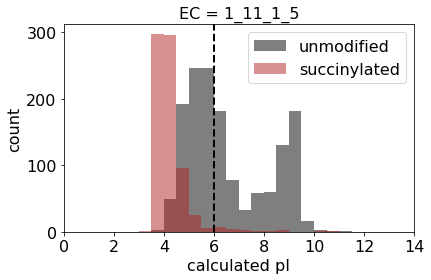

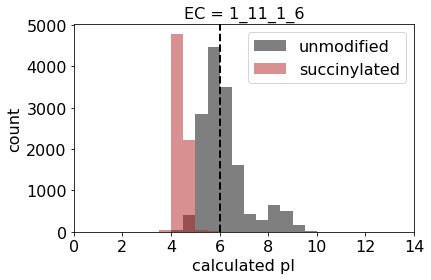

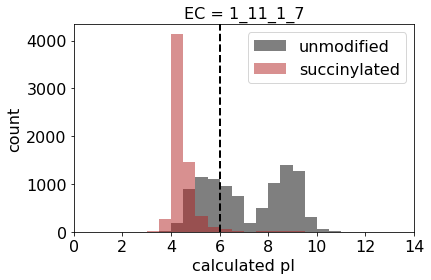

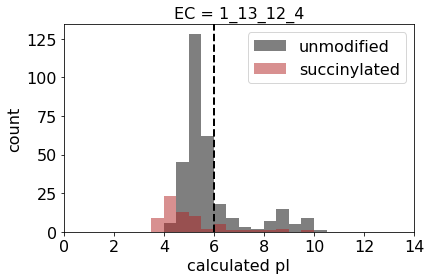

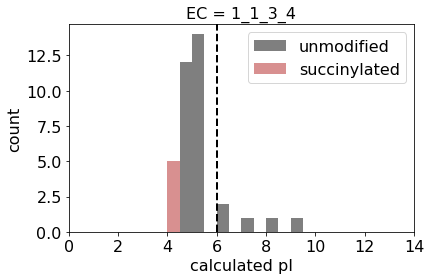

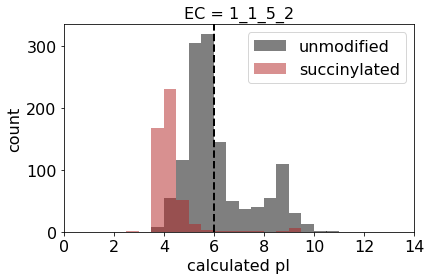

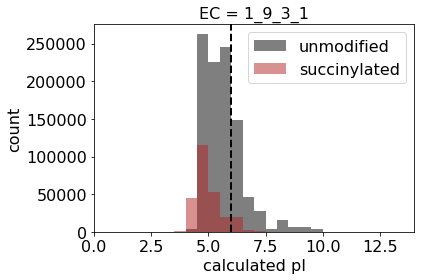

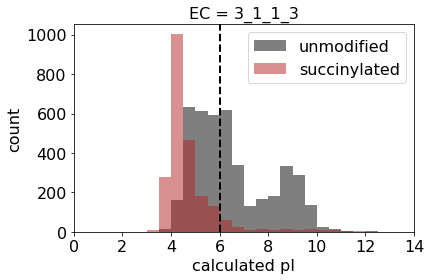

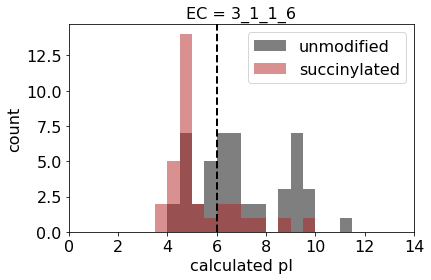

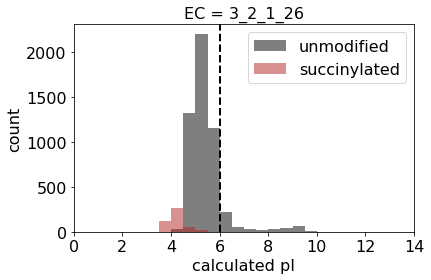

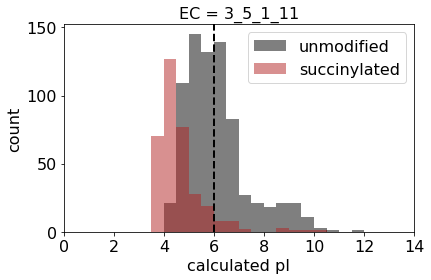

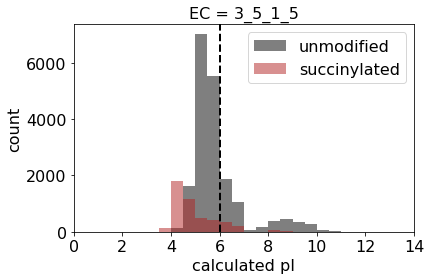

In [9]:
print('calculate all pIs for target EC sequences')
for EC_file in database_names:
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    print('doing:', EC_file)
    file_mod = EC_file.replace(".fasta", "_mod.fasta")
    if redo_pi is True:
        pi_fn.calculate_pI_from_file(file_mod, param_dict, output_dir)
    print('plot distribution of pIs')
    pi_data = pd.read_csv(output_dir+param_dict['out_CSV_pi'], index_col=False)
    EC_pi_data = pi_data[pi_data['fasta_file'] == file_mod]
    pi_fn.plot_EC_pI_dist(EC_pi_data, param_dict,
                          filename=file_mod.replace('.fasta', '.pdf'),
                          title=file_mod.replace(output_dir, '').replace('__BRENDA_sequences_mod.fasta', ''))
    print('done')

(0, 30000)

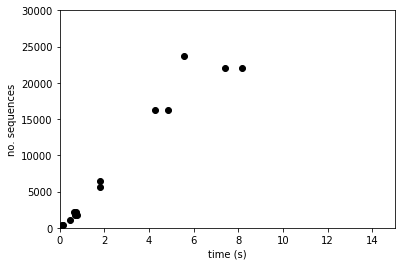

In [10]:
times = [0.74, 8.18, 4.85, 0.13, 0.02, 0.78, 
         0.62, 7.42, 4.26, 0.11, 0.01, 0.67, 
         300.89, 1.81, 0.03, 1.82, 0.44, 5.56]
seqs = [2220, 22068, 16288, 379, 36, 1765, 2220,
        22068, 16288, 379, 36, 1765, 1253592,
        6487, 80, 5665, 1098, 23660]
plt.scatter(times, seqs, c='k')
plt.xlabel('time (s)')
plt.ylabel('no. sequences')
plt.xlim(0, 15)
plt.ylim(0, 30000)

# Collect pI of species used in Literature data base using BRENDA

In [11]:
# get parameters
param_dict = parameters.get_parameters()

# input parameters
database_directory = '/home/atarzia/psp/sequence_db/bio_min_dataset/'
output_dir = database_directory

In [12]:
# set EC numbers of interest based on dataset
# 'none' in species lists implies species was not given with literature report.
EC_set = {
    # EC : species list
    '1.11.1.5': ['equus caballus', ],
    '1.11.1.6': ['bos taurus', ],
    '1.11.1.7': ['armoracia rusticana', ],
    '1.9.3.1': ['equus caballus', ],
    '1.1.5.2': ['none', ],
    '3.5.1.5': ['canavalia ensiformis'],
    '1.1.3.4': ['aspergillus niger'],
    '1.13.12.4': ['none'],
    '3.2.1.26': ['none'],
    '3.1.1.3': ['thermomyces lanuginosus', 'alcaligenes sp.',
                'pseudomonas fluorescens',
                'rhizomucor miehei', 'candida antarctica',
                'aspergillus niger'],
    '3.1.1.6': ['lactobacillus acidophilus'],
    '3.5.1.11': ['none'],
    }

In [13]:
# read in pI output file
pi_data = pd.read_csv(output_dir+param_dict['out_CSV_pi'], index_col=False)

In [14]:
print('Screen all Enzymes in EC Classes using BRENDA data')
count_done = 0
total_start_time = time.time()
for EC_file in database_names:
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    print('-----------------------------------------------')
    print('doing:', EC_file)
    file_mod = EC_file.replace(".fasta", "_mod.fasta")
    EC_pi_data = pi_data[pi_data['fasta_file'] == file_mod]
    # only keep those that pass the pI test
    pi_passed_data = EC_pi_data[EC_pi_data['pi'] < param_dict['cutoff_pi']]
    print('--- ', 
          len(pi_passed_data), 'proteins out of', len(EC_pi_data), 
          'remain, OR', int(len(pi_passed_data)/len(EC_pi_data)*100),
          "% ---")
    EC_no = list(set(EC_pi_data['EC.code']))[0].replace(' ', '').replace(".", "_")
    print('EC:', EC_no.replace("_", "."))
    br_datafile = 'brenda_download_'+EC_no+'.txt'
    # convert br_datafile into dictionary
    br_symbols, br_data = brenda_IO.get_brenda_dict(param_dict['BRENDA_DB_loc']+br_datafile)
    # from here is quite bio-min assay literature specific - although the code can be reused
    # get species of interest from known EC records
    species_of_interest = EC_set[EC_no.replace('_', '.')]
    for spec in species_of_interest:
        print('species:', spec)
        # is species in sequence data?
        spec_in_seq, spec_in_br = brenda_IO.is_species_reported(spec, 
                                                                EC_pi_data, 
                                                                br_data, 
                                                                verbose=True)
        PR_of_int = []
        for i in sorted(br_data['PR']):
            if spec in i.lower():
                # this assumes that the first item of each line is always "#"
                PR_info = i.split("#")[1]            
                if PR_info not in PR_of_int:
                    PR_of_int.append(PR_info)
        # get pI from BRENDA
        prop_of_int = 'PI'
        list_of_int = br_data[prop_of_int]
        # get list of protein codes with property of interest
        EC_prop_PR_codes = brenda_IO.get_prop_PR_codes(list_of_int)
        value_of_int = {}
        for PR in PR_of_int:
            if PR in set([j for i in EC_prop_PR_codes.values() for j in i ]):
                print('protein code:', PR, 'has', prop_of_int, 'in BRENDA')
            else:
                print('protein code:', PR, 'does not have', prop_of_int, 'in BRENDA')
            values = [list_of_int[i].split(" ")[1] 
                      for i in EC_prop_PR_codes.keys() if PR in EC_prop_PR_codes[i]]
            # apply property specific rules
            # check for ranges - append min and max
            values_min = [i.split('-')[0] for i in values if '-' in i and i[0] != '-']
            values_max = [i.split('-')[1] for i in values if '-' in i and i[0] != '-']
            if len(values_min) > 0 and len(values_max) > 0:
                for i in np.arange(len(values)-1, -1, -1):
                    if '-' in values[i]:
                        del values[i]
                print(values_min, values_max)
                values.append(values_min[0])
                values.append(values_max[0])
            # PI == float
            values = [float(i) for i in values]
            # PI => between 0 and 14
            values = [i for i in values if i >= 0 and i <= 14]
            if len(values) > 0:
                value_of_int[PR] = values
        print('reported pIs in BRENDA:', value_of_int.values())
    count_done += 1
print('--- finished %s EC classes in %s seconds ---' % (count_done, '{0:.2f}'.format(time.time() - total_start_time)))

Screen all Enzymes in EC Classes using BRENDA data
-----------------------------------------------
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_5__BRENDA_sequences.fasta
---  1459 proteins out of 2220 remain, OR 65 % ---
EC: 1.11.1.5
species: equus caballus
species in sequence data: False
species in BRENDA data: False
reported pIs in BRENDA: dict_values([])
-----------------------------------------------
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_6__BRENDA_sequences.fasta
---  14865 proteins out of 22068 remain, OR 67 % ---
EC: 1.11.1.6
species: bos taurus
species in sequence data: True
species in BRENDA data: True
protein code: 12 has PI in BRENDA
protein code: 138 does not have PI in BRENDA
reported pIs in BRENDA: dict_values([[5.4]])
-----------------------------------------------
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_7__BRENDA_sequences.fasta
---  9633 proteins out of 16288 remain, OR 59 % ---
EC: 1.11.1.7
species: armoracia rus

# From the list of reactions reported in the literature - determine, which molecules fit in ZIF-8

In [15]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticklabels(['diffuses', 'does not diffuse'])
    ax.set_xticks([0.25, 0.75])


def define_parity_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


In [16]:
# set EC numbers of interest based on dataset
# 'none' in species lists implies species was not given with literature report.
EC_mol_set = {
    # EC : species list : unique molecules
    '1.11.1.5': {'equus caballus': [
        ('hydrogen peroxide', 'OO'),
        ('pyrogallol', 'C1=CC(=C(C(=C1)O)O)O'),
        ('purporogallin', 'C1=CC(=O)C(=C2C(=C1)C=C(C(=C2O)O)O)O'),
    ]},
    '1.11.1.6': {'bos taurus': [
        ('hydrogen peroxide', 'OO'),
        ('water', 'O'),
        ('oxygen', 'O=O'),
        ('3-amino-1,2,4-triazole', 'C1=NNC(=N1)N'),
    ]},
    '1.11.1.7': {'armoracia rusticana': [
        ('pyrogallol', 'C1=CC(=C(C(=C1)O)O)O'),
        ('purporogallin', 'C1=CC(=O)C(=C2C(=C1)C=C(C(=C2O)O)O)O'),
        ('hydrogen peroxide', 'OO'),
        ('water', 'O'),
        ('oxygen', 'O=O'),
        ('ABTS', 'CCN1C2=C(C=C(C=C2)S(=O)(=O)[O-])SC1=NN=C3N(C4=C(S3)C=C(C=C4)S(=O)(=O)[O-])CC'),
    ]},
    '1.9.3.1': {'equus caballus': [
        ('hydrogen peroxide', 'OO'),
        ('water', 'O'),
        ('oxygen', 'O=O'),
        ('ABTS', 'CCN1C2=C(C=C(C=C2)S(=O)(=O)[O-])SC1=NN=C3N(C4=C(S3)C=C(C=C4)S(=O)(=O)[O-])CC'),
        ('Amplex Red', 'CC(=O)N1C2=C(C=C(C=C2)O)OC3=C1C=CC(=C3)O'),
        ('resorufin', 'C1=CC2=C(C=C1O)OC3=CC(=O)C=CC3=N2'),
        ('methyl ethyl ketone peroxide', 'CCC(C)(OO)OOC(C)(CC)OO'),
        ('tert-butyl hydroperoxide', 'CC(C)(C)OO'),
    ]},
    '1.1.5.2': {'none': [
        ('methosulfate', 'COS(=O)(=O)[O-]'),
        ('5-Methylphenazin-5-ium', 'C[N+]1=C2C=CC=CC2=NC3=CC=CC=C31'),
        ('2,6-dichloroindophenol', 'C1=CC(=O)C=CC1=NC2=CC(=C(C(=C2)Cl)O)Cl'),
    ]},
    '3.5.1.5': {'canavalia ensiformis': [
        ('Urea', 'C(=O)(N)N'),
        ('water', 'O'),
        ('carbon dioxide', 'C(=O)=O'),
        ('ammonia', 'N'),
    ]},
    '1.1.3.4': {'aspergillus niger': [
        ('D-glucose (chain)', 'C(C(C(C(C(C=O)O)O)O)O)O'),
        ('D-glucose (ring)', 'C(C1C(C(C(C(O1)O)O)O)O)O'),
        ('gluconic acid', 'C(C(C(C(C(C(=O)O)O)O)O)O)O'),
        ('hydrogen peroxide', 'OO'),
        ('Gluconolactone', 'C(C1C(C(C(C(=O)O1)O)O)O)O'),
    ]},
    '1.13.12.4': {'none': [
        ('hydrogen peroxide', 'OO'),
        ('pyruvate', 'CC(=O)C(=O)[O-]'),
        ('L-lactate', 'CC(C(=O)[O-])[O-]'),
        
    ]},
    '3.2.1.26': {'none': [
        ('sucrose', 'C(C1C(C(C(C(O1)OC2(C(C(C(O2)CO)O)O)CO)O)O)O)O'),
        ('L-fructose', 'C(C(C(C(C(=O)CO)O)O)O)O'),
        ('D-fructose', 'C1C(C(C(C(O1)(CO)O)O)O)O'),
    ]},
    '3.1.1.3': {'thermomyces lanuginosus': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ],
                'alcaligenes sp.': [  # not sure about this one - the kinetic resolution may not belong to this enyzme?
                    ('2-octanol', 'CCCCCCC(C)O'),
                    ('vinyl acetate', 'CC(=O)OC=C'),
                    ('octyl acetate', 'CCCCCCCCOC(=O)C'),
                    ('p-nitrophenyl', 'C1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('p-nitrophenyl octanoate', 'CCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('octanoic acid', 'CCCCCCCC(=O)O'),
                ],
                'pseudomonas fluorescens': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ],
                'rhizomucor miehei': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ], 
                'candida antarctica': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ],
                'aspergillus niger': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl acetate', 'CC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('acetic acid', 'CC(=O)O'),
                ]},
    '3.1.1.6': {'lactobacillus acidophilus': [
        ('p-nitrophenyl', 'C1=CC=C(C=C1)[N+](=O)[O-]'),
        ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
        ('p-nitrophenyl acetate', 'CC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('acetic acid', 'CC(=O)O'),
        ('p-nitrophenyl phosphate', 'C1=CC(=CC=C1[N+](=O)[O-])OP(=O)(O)O'),
        ('phosphate acid', 'OP(=O)([O-])[O-]'),
        ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('butyric acid', 'CCCC(=O)O'),
        ('p-nitrophenyl hexanoate', 'CCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('hexanoic acid', 'CCCCCC(=O)O'),
        ('p-nitrophenyl octanoate', 'CCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('octanoic acid', 'CCCCCCCC(=O)O'),
        ('p-nitrophenyl decanoate', 'CCCCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('decanoic acid', 'CCCCCCCCCC(=O)O'),
        ('p-nitrophenyl dodecanoate', 'CCCCCCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('dodecanoic acid', 'CCCCCCCCCCCC(=O)O'),
    ]},
    '3.5.1.11': {'none': [
        ('penicillin-G', 'CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C'),
    ]},
    }

In [17]:
# get parameters
param_dict = parameters.get_parameters()
threshold = float(param_dict['diffuse_threshold'])
# input parameters
database_directory = '/home/atarzia/psp/screening_results/biomin_known/'
output_dir = database_directory

In [18]:
# get all unique molecules and draw 2D structures
molecules = {}
diameters = {}
for i in EC_mol_set.keys():
    for j in EC_mol_set[i].keys():
        for mol in EC_mol_set[i][j]:
            molecules[mol[0]] = mol[1]
            diameters[mol[0]] = 0
            rdkit_functions.draw_smiles_to_svg(mol[1], output_dir+mol[0].replace(' ', '_')+'_2d.svg')

#### calculate size

In [22]:
rdkit_functions.calc_molecule_diameters(molecules, diameters, 
                                        out_dir=output_dir, vdwScale=0.8, boxMargin=4.0,
                                        spacing=0.6, show_vdw=False, plot_ellip=False,
                                        N_conformers=50, MW_thresh=2000,
                                        show_conf=False)

!! calc_molecule_diameters needs documentation !!
molecule: hydrogen peroxide : SMILES: OO
!! calc_molecule_diameter needs documentation !!
1 out of 46 done
molecule: pyrogallol : SMILES: C1=CC(=C(C(=C1)O)O)O
!! calc_molecule_diameter needs documentation !!
2 out of 46 done
molecule: purporogallin : SMILES: C1=CC(=O)C(=C2C(=C1)C=C(C(=C2O)O)O)O
!! calc_molecule_diameter needs documentation !!
3 out of 46 done
molecule: water : SMILES: O
!! calc_molecule_diameter needs documentation !!
4 out of 46 done
molecule: oxygen : SMILES: O=O
!! calc_molecule_diameter needs documentation !!
5 out of 46 done
molecule: 3-amino-1,2,4-triazole : SMILES: C1=NNC(=N1)N
!! calc_molecule_diameter needs documentation !!
6 out of 46 done
molecule: ABTS : SMILES: CCN1C2=C(C=C(C=C2)S(=O)(=O)[O-])SC1=NN=C3N(C4=C(S3)C=C(C=C4)S(=O)(=O)[O-])CC
!! calc_molecule_diameter needs documentation !!
7 out of 46 done
molecule: Amplex Red : SMILES: CC(=O)N1C2=C(C=C(C=C2)O)OC3=C1C=CC(=C3)O
!! calc_molecule_diameter needs doc

#### get results

In [23]:
threshold = float(param_dict['diffuse_threshold'])
diffuse = {}
no_diffuse = {}
count = 0
for name, smile in molecules.items():
    out_file = output_dir+name.replace(' ', '_')+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    count += 1
    results = pd.read_csv(out_file)
    min_diam = min(results['diam1'])
    mid_diam = min(results['diam2'])
    # print(min(results['diam1']))
    # print(min(results['diam2']))
    # plt.hist(results['diam1'], facecolor='k', alpha=0.4)
    # plt.hist(results['diam2'], facecolor='r', alpha=0.4)
    if mid_diam <= threshold:
        print(name+':')
        print('can diffuse')
        print('min diameter =', round(min_diam, 3), 'angstrom')
        print('mid diameter =', round(mid_diam, 3), 'angstrom')
        diffuse[name] = smile
    else:
        print(name+':')
        print('cannot diffuse')
        print('min diameter =', round(min_diam, 3), 'angstrom')
        print('mid diameter =', round(mid_diam, 3), 'angstrom')
        no_diffuse[name] = smile
    print('-')
print('analyzed ', count, 'molecules')

hydrogen peroxide:
can diffuse
min diameter = 2.758 angstrom
mid diameter = 3.093 angstrom
-
pyrogallol:
cannot diffuse
min diameter = 3.205 angstrom
mid diameter = 7.227 angstrom
-
purporogallin:
cannot diffuse
min diameter = 4.218 angstrom
mid diameter = 8.725 angstrom
-
water:
can diffuse
min diameter = 2.492 angstrom
mid diameter = 2.586 angstrom
-
oxygen:
can diffuse
min diameter = 2.841 angstrom
mid diameter = 2.9 angstrom
-
3-amino-1,2,4-triazole:
cannot diffuse
min diameter = 3.044 angstrom
mid diameter = 5.326 angstrom
-
ABTS:
cannot diffuse
min diameter = 6.284 angstrom
mid diameter = 9.054 angstrom
-
Amplex Red:
cannot diffuse
min diameter = 5.202 angstrom
mid diameter = 10.216 angstrom
-
resorufin:
cannot diffuse
min diameter = 3.403 angstrom
mid diameter = 7.065 angstrom
-
methyl ethyl ketone peroxide:
cannot diffuse
min diameter = 5.76 angstrom
mid diameter = 7.486 angstrom
-
tert-butyl hydroperoxide:
cannot diffuse
min diameter = 5.347 angstrom
mid diameter = 5.816 angst

#### Plot categorical scatter plot

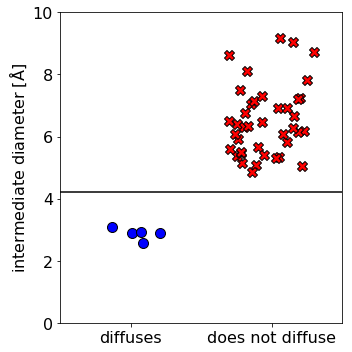

In [24]:
threshold = float(param_dict['diffuse_threshold'])
dx = 0.15
fig, ax = plt.subplots(figsize=(5,5))
for name, smile in molecules.items():
    out_file = output_dir+name.replace(' ', '_')+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    results = pd.read_csv(out_file)
    mid_diam = min(results['diam2'])
    if mid_diam <= threshold:
        C = 'b'
        M = 'o'
        E = 'k'
        D = 0.25
    else:
        C = 'r'
        M = 'X'
        E = 'k'
        D = 0.75
    ax.scatter(D+(dx*(np.random.random() - 0.5) * 2),
               mid_diam, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
ax.axhline(y=threshold, c='k')
define_plot_variables(ax,
                      title='',
                      xtitle='',
                      ytitle='intermediate diameter [$\mathrm{\AA}$]',
                      xlim=(0, 1),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"categorical.pdf", dpi=720,
            bbox_inches='tight')

#### Plot shapes

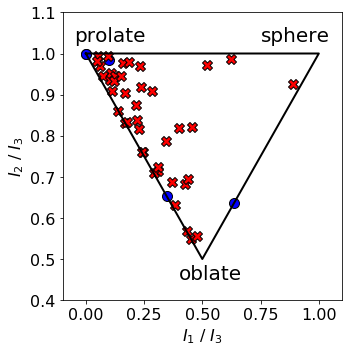

In [25]:
threshold = float(param_dict['diffuse_threshold'])
fig, ax = plt.subplots(figsize=(5,5))
for name, smile in molecules.items():
    out_file = output_dir+name.replace(' ', '_')+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    results = pd.read_csv(out_file)
    mid_diam = min(results['diam2'])
    if mid_diam <= threshold:
        C = 'b'
        M = 'o'
        E = 'k'
        D = 0.25
    else:
        C = 'r'
        M = 'X'
        E = 'k'
        D = 0.75
    ax.scatter(np.average(results['ratio_1']),
               np.average(results['ratio_2']),
               c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
ax.plot([0, 0.5, 1, 0], [1, 0.5, 1, 1], c='k', lw=2)
ax.text(0.75, 1.03, 'sphere', fontsize=20)
ax.text(0.4, 0.45, 'oblate', fontsize=20)
ax.text(-0.05, 1.03, 'prolate', fontsize=20)
define_parity_plot_variables(ax,
                             title='',
                             xtitle='$I_1$ / $I_3$',
                             ytitle='$I_2$ / $I_3$',
                             xlim=(-0.1, 1.1),
                             ylim=(0.4, 1.1))
fig.tight_layout()
fig.savefig(output_dir+"shape.pdf", dpi=720,
            bbox_inches='tight')

# Collect reactant-product systems 
suggest new reactions!

### Collect all reaction systems from multiple databases
Online.

In [109]:
# set output directory
output_dir = '/home/atarzia/psp/screening_results/biomin_search/'

# set databases to search to collect reaction systems
# BKMS should always be last as the culmination of all DBs
Databases = ['SABIO', 'KEGG', 'BKMS']

# set EC numbers of interest
EC_int = ['1.11.1.5', '1.11.1.6', '1.11.1.7', '1.9.3.1',
          '1.1.5.2', '3.5.1.5', '1.1.3.4', '1.13.12.4',
          '3.2.1.26', '3.1.1.3', '3.1.1.6', '3.5.1.11']

In [119]:
for DB in Databases:
    # get database specific information
    DB_prop = DB_functions.get_DB_prop(DB)
    db_dir = DB_prop[0]
    # iterate over EC numbers of interest
    for EC in EC_int:
        rxn_syst.get_reaction_systems(EC, DB, output_dir)

39 matching entries found.
DB: SABIO - EC: 1.11.1.5 - DB ID: 23571 - 0 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23572 - 1 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23573 - 2 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23574 - 3 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23575 - 4 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23576 - 5 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23577 - 6 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23578 - 7 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23579 - 8 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23580 - 9 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23581 - 10 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 -

67 matching entries found.
DB: SABIO - EC: 1.11.1.7 - DB ID: 19982 - 0 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19983 - 1 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19984 - 2 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19985 - 3 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19986 - 4 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19987 - 5 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19988 - 6 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19989 - 7 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19990 - 8 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2033 - 9 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2034 - 10 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - D

51 matching entries found.
DB: SABIO - EC: 1.1.3.4 - DB ID: 11576 - 0 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11577 - 1 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11578 - 2 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11579 - 3 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11580 - 4 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11581 - 5 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11582 - 6 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11583 - 7 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11584 - 8 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11585 - 9 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11586 - 10 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 1158

72 matching entries found.
DB: SABIO - EC: 3.1.1.3 - DB ID: 21245 - 0 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21246 - 1 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21247 - 2 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21248 - 3 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21249 - 4 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21250 - 5 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21251 - 6 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21252 - 7 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21253 - 8 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21254 - 9 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 22631 - 10 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 2263

DB: KEGG - EC: 1.9.3.1 - DB ID: R00081 - 0 of 2
-----------------------------------
DB: KEGG - EC: 1.9.3.1 - DB ID: R00082 - 1 of 2
-----------------------------------
DB: KEGG - EC: 1.1.5.2 - DB ID: R06620 - 0 of 1
-----------------------------------
DB: KEGG - EC: 3.5.1.5 - DB ID: R00131 - 0 of 2
-----------------------------------
DB: KEGG - EC: 3.5.1.5 - DB ID: R06134 - 1 of 2
-----------------------------------
DB: KEGG - EC: 1.1.3.4 - DB ID: R01522 - 0 of 1
-----------------------------------
DB: KEGG - EC: 1.13.12.4 - DB ID: R00319 - 0 of 1
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R00801 - 0 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R00802 - 1 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R02410 - 2 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R03635 - 3 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R03921 - 4 of 9
---------------------

RDKit WARNING: [11:37:45]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.11.1.6 - DB ID: 2570 - 1 of 5


RDKit WARNING: [11:37:47]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.11.1.6 - DB ID: 8219 - 2 of 5
-----------------------------------
DB: BKMS - EC: 1.11.1.6 - DB ID: 16541 - 3 of 5
reaction is reversible


RDKit WARNING: [11:37:51]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.11.1.6 - DB ID: 27391 - 4 of 5
-----------------------------------
DB: BKMS - EC: 1.11.1.7 - DB ID: 8220 - 0 of 15
-----------------------------------
DB: BKMS - EC: 1.11.1.7 - DB ID: 9909 - 1 of 15
DB: BKMS - EC: 1.11.1.7 - DB ID: 11029 - 2 of 15
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: BKMS - EC: 1.11.1.7 - DB ID: 16531 - 3 of 15
DB: BKMS - EC: 1.11.1.7 - DB ID: 16751 - 4 of 15
reaction is reversible
skipping this molecule because it contains:  lignin
-----------------------------------
DB: BKMS - EC: 1.11.1.7 - DB ID: 16770 - 5 of 15
reaction is reversible
skipping this molecule because it contains:  lignin
-----------------------------------
DB: BKMS - EC: 1.11.1.7 - DB ID: 18109 - 6 of 15
DB: BKMS - EC: 1.11.1.7 - DB ID: 20607 - 7 of 15
DB: BKMS - EC: 1.11.1.7 - DB ID: 22498 - 8 of 15
no match in DB
-----------------------------------
D

RDKit WARNING: [11:38:20]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.9.3.1 - DB ID: 16228 - 1 of 5
reaction is reversible


RDKit WARNING: [11:38:24]  S group SUP ignored on line 8


molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: BKMS - EC: 1.9.3.1 - DB ID: 20405 - 2 of 5
DB: BKMS - EC: 1.9.3.1 - DB ID: 23403 - 3 of 5
DB: BKMS - EC: 1.9.3.1 - DB ID: 55972 - 4 of 5
no match in DB
no match in DB
-----------------------------------
DB: BKMS - EC: 1.1.5.2 - DB ID: 10094 - 0 of 2
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
structure could not be deciphered
probably a polymeric structure - skipping.


RDKit ERROR: [11:38:43]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.
RDKit ERROR: [11:38:44]  Unhandled CTAB feature: S group SRU on line: 43. Molecule skipped.


structure could not be deciphered
probably a polymeric structure - skipping.
-----------------------------------
DB: BKMS - EC: 1.1.5.2 - DB ID: 42759 - 1 of 2
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: BKMS - EC: 3.5.1.5 - DB ID: 496 - 0 of 2
-----------------------------------
DB: BKMS - EC: 3.5.1.5 - DB ID: 500 - 1 of 2
-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 1223 - 0 of 7


RDKit WARNING: [11:39:02]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 1474 - 1 of 7
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 1646 - 2 of 7
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.


RDKit WARNING: [11:39:24]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 6736 - 3 of 7
no match in DB
-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 6739 - 4 of 7
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.


RDKit WARNING: [11:39:33]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 14182 - 5 of 7
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.


RDKit WARNING: [11:39:41]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 16199 - 6 of 7
reaction is reversible


RDKit WARNING: [11:39:44]  S group SUP ignored on line 8


molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: BKMS - EC: 1.13.12.4 - DB ID: 2130 - 0 of 2


RDKit WARNING: [11:39:52]  S group SUP ignored on line 8


-----------------------------------
DB: BKMS - EC: 1.13.12.4 - DB ID: 10874 - 1 of 2


RDKit WARNING: [11:39:54]  S group SUP ignored on line 8


molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: BKMS - EC: 3.2.1.26 - DB ID: 10395 - 0 of 11
no match in DB
no match in DB
-----------------------------------
DB: BKMS - EC: 3.2.1.26 - DB ID: 11007 - 1 of 11
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: BKMS - EC: 3.2.1.26 - DB ID: 11280 - 2 of 11
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: BKMS - EC: 3.2.1.26 - DB ID: 11374 - 3 of 11
-----------------------------------
DB: BKMS - EC: 3.2.1.26 - DB ID: 11426 - 4 of 11
molecule does not have recorded structure in CHEBI DB
probably a generic structure - skipping.
-----------------------------------
DB: BKMS - EC: 3.2.1.26 - DB ID: 1

RDKit WARNING: [11:43:04]  S group SUP ignored on line 37
RDKit WARNING: [11:43:04]  S group SUP ignored on line 37


-----------------------------------
DB: BKMS - EC: 3.5.1.11 - DB ID: 62670 - 4 of 6
DB: BKMS - EC: 3.5.1.11 - DB ID: 65240 - 5 of 6
no match in DB
-----------------------------------


### Check all reaction systems for if they fit through MOF
Not DB dependant.
Offline.

In [120]:
mol_output_file = output_dir+'screening_output.csv'
# get parameters
param_dict = parameters.get_parameters()
threshold = float(param_dict['diffuse_threshold'])

In [121]:
molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')

In [147]:
# iterate over reaction system files
count = 0
for rsf in react_syst_files:
    _rsf = rsf.replace(output_dir+'sRS-', '').replace('.pkl', '')
    EC_, DB, DB_ID = _rsf.split('-')
    EC = EC_.replace("_", ".")
    print('DB:', DB, '- EC:', EC, '-',
          'DB ID:', DB_ID, '-', count, 'of', len(react_syst_files))
    rs = rxn_syst.reaction(EC, DB, DB_ID)
    count += 1
    if os.path.isfile(output_dir+rs.pkl) is False:
        print('you have not collected all reaction systems.')
        print('Exitting.')
        import sys
        sys.exit()
    # load in rxn system
    rs = rs.load_object(output_dir+rs.pkl)
    if rs.skip_rxn is True:
        print('skipping reaction....')
        continue
    
    # define reactants and products dict
    # name: (smile, DB, DB_ID, iupac_name, role)
    components_dict = {}
    
    # ignore any reactions with unknown components
    rs.skip_rxn = False
    for m in rs.components:
        if m.mol is None:
            rs.skip_rxn = True
    
    if rs.skip_rxn is True:
        print('skipping reaction - it is incomplete or generic')
        rs.save_object(output_dir+rs.pkl)
        continue
    for m in rs.components:
        # get IUPAC NAME
        iupac_name = None
        print("!! NEED TO GET IUPAC NAME !!")
        smile = Chem.MolToSmiles(Chem.RemoveHs(m.mol))
        # note that for SABIO we do not have IUPAC names
        components_dict[m.name] = (smile, m.DB, m.DB_ID, iupac_name, m.role.lower())
    
    # calculate molecule size of all components
    # save to molecule output files
    molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
    DB_functions.get_molecule_diameters(components_dict,
                                        molecule_output=molecule_output,
                                        mol_output_file=mol_output_file, db_dir=db_dir,
                                        vdwScale=0.8, boxMargin=4.0, 
                                        spacing=0.6, N_conformers=50, MW_thresh=200)
    
    molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
    
    # get diameters (should alrady be calculated) 
    # of all components of reaction
    rs.check_all_fit(threshold, molecule_output)
    rs.save_object(output_dir+rs.pkl)
    print('-----------------------------------')

DB: SABIO - EC: 1.11.1.6 - DB ID: 23680 - 0 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-23680.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 23680
-----------------------------------
H2O  (ID: 40) as product
O2  (ID: 1264) as product
H2O2  (ID: 1909) as reactant
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38326 - 1 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_5-SABIO-38326.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R06088 - 2 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-KEGG-R06088.pkl
!

-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44768 - 28 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44768.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44768
-----------------------------------
H2O  (ID: 40) as product
O2  (ID: 1264) as product
H2O2  (ID: 1909) as reactant
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 49709 - 29 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-SABIO-49709.pkl
skipping reaction....
DB: SABIO - EC: 1.11.1.6 - DB ID: 44756 - 30 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44756.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----

-----------------------------------
DB: BKMS - EC: 1.13.12.4 - DB ID: 2130 - 57 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_13_12_4-BKMS-2130.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23601 - 58 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_5-SABIO-23601.pkl
skipping reaction....
DB: SABIO - EC: 3.1.1.3 - DB ID: 49726 - 59 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-SABIO-49726.pkl
skipping reaction....
DB: SABIO - EC: 1.11.1.6 - DB ID: 44748 - 60 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44748.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44748
------------

-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 33387 - 82 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_5-SABIO-33387.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 50723 - 83 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-SABIO-50723.pkl
skipping reaction....
DB: SABIO - EC: 1.11.1.7 - DB ID: 235 - 84 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_7-SABIO-235.pkl
skipping reaction....
DB: SABIO - EC: 1.11.1.5 - DB ID: 23584 - 85 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_5-SABIO-23584.pkl
skipping reaction....
DB: SABIO - EC: 1.11.1.6 - DB ID: 44724 - 86 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44724.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME

-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 12527 - 113 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-SABIO-12527.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37092 - 114 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-SABIO-37092.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 728 - 115 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_11-SABIO-728.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14942 - 116 of 666
loading: /home/atarzia/psp/screening

-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 22635 - 145 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-SABIO-22635.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 3735 - 146 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_7-SABIO-3735.pkl
skipping reaction....
DB: SABIO - EC: 3.2.1.26 - DB ID: 37089 - 147 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-SABIO-37089.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 9601 - 148 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-9601.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC N

-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 49730 - 174 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-SABIO-49730.pkl
skipping reaction....
DB: BKMS - EC: 3.2.1.26 - DB ID: 17496 - 175 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-BKMS-17496.pkl
skipping reaction....
DB: SABIO - EC: 1.11.1.6 - DB ID: 9633 - 176 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-9633.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 9633
-----------------------------------
H2O  (ID: 40) as product
O2  (ID: 1264) as product
H2O2  (ID: 1909) as reactant
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 49698 - 177 of 666
loading: /home/atarz

-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 40237 - 208 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-SABIO-40237.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44785 - 209 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44785.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44785
-----------------------------------
H2O  (ID: 40) as product
O2  (ID: 1264) as product
H2O2  (ID: 1909) as reactant
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44754 - 210 of 666
loading: /home/atarzia/psp/screening_results/

-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 11611 - 239 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_11-SABIO-11611.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 33384 - 240 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_5-SABIO-33384.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 6096 - 241 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_1_3_4-SABIO-6096.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 18326 - 242 of 666
loading: /home/atarzia/psp/screening_r

-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21252 - 269 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-SABIO-21252.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14947 - 270 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_11-SABIO-14947.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44745 - 271 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44745.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44745
-----------------------------------
H2O

-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37084 - 299 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-SABIO-37084.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 33386 - 300 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_5-SABIO-33386.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44726 - 301 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44726.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44726
-----------------------------------
H2O  (ID: 40) as product
O2  (ID

-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 6736 - 330 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_1_3_4-BKMS-6736.pkl
skipping reaction....
DB: SABIO - EC: 3.1.1.3 - DB ID: 49705 - 331 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-SABIO-49705.pkl
skipping reaction....
DB: SABIO - EC: 1.11.1.7 - DB ID: 58998 - 332 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_7-SABIO-58998.pkl
skipping reaction....
DB: SABIO - EC: 3.5.1.11 - DB ID: 11612 - 333 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_11-SABIO-11612.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: BKMS - EC: 3.1.1.3 - DB ID: 6171 - 334 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-BKMS-6171.pkl
skipping reaction....
DB: KEGG - EC: 1.11.1.5 - DB ID: 

-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 6385 - 362 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_7-SABIO-6385.pkl
skipping reaction....
DB: SABIO - EC: 3.5.1.5 - DB ID: 38319 - 363 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_5-SABIO-38319.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44773 - 364 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44773.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44773
-----------------------------------
H2O  (ID: 40) as product
O2  (ID: 1264) as product
H2O2  (ID: 1909) as reactant
-----------------------------------
All components will diffuse through!
-----------

-----------------------------------
DB: BKMS - EC: 3.2.1.26 - DB ID: 41624 - 393 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-BKMS-41624.pkl
skipping reaction....
DB: SABIO - EC: 1.11.1.7 - DB ID: 232 - 394 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_7-SABIO-232.pkl
skipping reaction....
DB: SABIO - EC: 1.11.1.7 - DB ID: 19982 - 395 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_7-SABIO-19982.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 48401 - 396 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-SABIO-48401.pkl
skipping reaction....
DB: SABIO - EC: 3.2.1.26 - DB ID: 36087 - 397 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-SABIO-36087.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC

-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37093 - 429 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-SABIO-37093.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: BKMS - EC: 3.5.1.11 - DB ID: 6210 - 430 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_11-BKMS-6210.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44747 - 431 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44747.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44747
-----------------------------------
H2O  (ID: 40) as product
O2  (ID: 

-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 35569 - 453 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_1_3_4-SABIO-35569.pkl
skipping reaction....
DB: SABIO - EC: 3.5.1.5 - DB ID: 42108 - 454 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_5-SABIO-42108.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 42129 - 455 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-SABIO-42129.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44780 - 456 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44780.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC

-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44749
-----------------------------------
H2O  (ID: 40) as product
O2  (ID: 1264) as product
H2O2  (ID: 1909) as reactant
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: SABIO - EC: 1.9.3.1 - DB ID: 53016 - 480 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_9_3_1-SABIO-53016.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 40235 - 481 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-SABIO-40235.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23592 - 

-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44730
-----------------------------------
H2O  (ID: 40) as product
O2  (ID: 1264) as product
H2O2  (ID: 1909) as reactant
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: BKMS - EC: 3.2.1.26 - DB ID: 26832 - 510 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-BKMS-26832.pkl
skipping reaction....
DB: SABIO - EC: 1.1.3.4 - DB ID: 11578 - 511 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_1_3_4-SABIO-11578.pkl
skipping reaction....
DB: BKMS - EC: 3.1.1.6 - DB ID: 20430 - 512 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_6-BKMS-20430.pkl
skipping reaction....
DB: SABIO - EC: 3.5.1.5 - DB ID: 38318 - 513 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_5-SABIO-38318.pkl
!! NEED TO GET IUPAC NAME !!
!! NEE

-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37085 - 545 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-SABIO-37085.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 42264 - 546 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-42264.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 42264
-----------------------------------
H2O  (ID: 40) as product
O2  (ID: 1264) as product
H2O2  (ID: 1909) as reactant
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: BKMS - EC: 3.2.1.26 - DB ID: 11280 - 547 of 666
loading: /home/atarzia/psp/screening_results/b

-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44758 - 574 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44758.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44758
-----------------------------------
H2O  (ID: 40) as product
O2  (ID: 1264) as product
H2O2  (ID: 1909) as reactant
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 9616 - 575 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_5-SABIO-9616.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 55895 - 576 of 666
loading: /home/atarzia/psp/screening_results/bi

-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14951 - 602 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_11-SABIO-14951.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 43734 - 603 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_5-SABIO-43734.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 44390 - 604 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-SABIO-44390.pkl
skipping reaction....
DB: SABIO - EC: 1.11.1.7 - DB ID: 3738 - 605 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_7-SABIO-3738.pkl
skipping reaction....
DB: SABIO - EC: 3.1.1.3 - DB ID: 49715 - 606 of 666
loadin

-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 52383 - 631 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-SABIO-52383.pkl
skipping reaction....
DB: SABIO - EC: 3.5.1.5 - DB ID: 38313 - 632 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_5-SABIO-38313.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 31815 - 633 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_1_3_4-SABIO-31815.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38323 - 634 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_5-SABIO-38323.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAM

-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44783
-----------------------------------
H2O  (ID: 40) as product
O2  (ID: 1264) as product
H2O2  (ID: 1909) as reactant
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 48544 - 664 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-SABIO-48544.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: KEGG - EC: 1.11.1.6 - DB ID: R00602 - 665 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-KEGG-R00602.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------


In [148]:
molecule_output

,name,iupac_name,DB,DB_ID,SMILE,role,min_diam,mid_diam,max_diam,ratio_1,ratio_2
0,H2O,NaN,SABIO,40,O,both,2.492,2.586,3.748,0.347,0.653
1,O2,NaN,SABIO,1264,[O],both,2.635,2.639,2.675,0.000,0.000
2,H2O2,NaN,SABIO,1909,OO,both,2.888,3.098,4.169,0.101,0.984
3,NH3,NaN,SABIO,1268,N,product,2.698,2.917,3.486,0.636,0.636
4,Urea,NaN,SABIO,1798,N=C(N)O,reactant,2.997,5.164,5.703,0.468,0.532
5,CO2,NaN,SABIO,1266,O=C=O,product,2.714,2.916,5.314,0.000,1.000
6,sucrose,NaN,KEGG,17992,OCC1OC(OC2(CO)OC(CO)C(O)C2O)C(O)C(O)C1O,reactant,0.000,0.000,0.000,0.000,0.000
7,beta-D-fructofuranose,NaN,KEGG,28645,O[CH2:1][C@@:2]1(O)O[C@H:5]([CH2:6]O)[C@@H:4](...,product,5.505,6.687,8.634,0.467,0.885
8,alpha-D-glucose,NaN,KEGG,17925,O[C@H:1]1O[C@H:5]([CH2:6]O)[C@@H:4](O)[C@H:3](...,product,4.635,7.354,8.556,0.411,0.699
9,raffinose,NaN,BKMS,16634,OC[C@H]1O[C@@](CO)(O[C@H]2O[C@H](CO[C@H]3O[C@H...,both,0.000,0.000,0.000,0.000,0.000


### Get subset of reaction systems that fit, with known protein sequences and checks if MOF can be seeded
DB dependant.
Online collection of Uniprot sequence.

In [149]:
param_dict = parameters.get_parameters()

In [150]:
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')

In [169]:
# iterate over reaction system files
count = 0
for rsf in react_syst_files:
    _rsf = rsf.replace(output_dir+'sRS-', '').replace('.pkl', '')
    EC_, DB, DB_ID = _rsf.split('-')
    EC = EC_.replace("_", ".")
    print('DB:', DB, '- EC:', EC, '-',
          'DB ID:', DB_ID, '-', count, 'of', len(react_syst_files))
    rs = rxn_syst.reaction(EC, DB, DB_ID)
    if os.path.isfile(output_dir+rs.pkl) is False:
        print('you have not collected all reaction systems.')
        print('Exitting.')
        import sys
        sys.exit()
    # load in rxn system
    rs = rs.load_object(output_dir+rs.pkl, verbose=False)
    count += 1
    if rs.skip_rxn is True:
        print('skipping reaction....')
        print('-----------------------------------')
        continue
    # this is only possible for reaction systems with UNIPROT ID
    if rs.UniprotID is None or rs.UniprotID == '':
        print('no sequence known')
        print('-----------------------------------')
        continue
        
    # split UniprotID for the cases where multiple subunits exist
    IDs = rs.UniprotID.split(" ")
    print('Uniprot IDs:', IDs)
    # do all components fit?
    if rs.all_fit is not True:
        print('cannot diffuse')
        print('-----------------------------------')
        continue
    # pI already checked?
    if rs.seed_MOF is not None:
        print('-----------------------------------')
        continue
    if len(IDs) > 0:
        # iterate over all UniProtIDs
        # assume all sequences require pI < cutoff for MOF growth
        # this is done by collating all sequences
        total_sequence = ''
        for i in IDs:
            sequence = Uniprot_IO.get_sequence(i)
            total_sequence += sequence
        rs = pi_fn.calculate_rxn_syst_pI(total_sequence, rs, param_dict=param_dict)
        rs.save_object(output_dir+rs.pkl)
        print('seed MOF?', rs.seed_MOF)
    else:
        rs.save_object(output_dir+rs.pkl)
        print('seed MOF?', rs.seed_MOF)
    print('-----------------------------------')

DB: SABIO - EC: 1.11.1.6 - DB ID: 23680 - 0 of 666
Uniprot IDs: ['Q939D2']
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38326 - 1 of 666
Uniprot IDs: ['P18314', 'P18315', 'P18316']
cannot diffuse
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R06088 - 2 of 666
no sequence known
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 44391 - 3 of 666
skipping reaction....
-----------------------------------
DB: BKMS - EC: 3.2.1.26 - DB ID: 11374 - 4 of 666
no sequence known
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14949 - 5 of 666
Uniprot IDs: ['P06875']
cannot diffuse
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 42948 - 6 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23599 - 7 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2289 - 8 of 666
Uniprot IDs: ['Q6PQF2']
cannot dif

DB: SABIO - EC: 3.1.1.3 - DB ID: 49698 - 177 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44712 - 178 of 666
Uniprot IDs: ['P46206']
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 48531 - 179 of 666
no sequence known
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 35572 - 180 of 666
Uniprot IDs: ['P81156']
cannot diffuse
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 49716 - 181 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 233 - 182 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 3736 - 183 of 666
skipping reaction....
-----------------------------------
DB: BKMS - EC: 3.1.1.6 - DB ID: 22361 - 184 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 49710 - 185 of 666
skipping reaction....
-------------------------------

skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 230 - 315 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 11610 - 316 of 666
Uniprot IDs: ['P06875']
cannot diffuse
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 227 - 317 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44741 - 318 of 666
Uniprot IDs: ['P29422']
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 11634 - 319 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 11624 - 320 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 53160 - 321 of 666
no sequence known
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44717 - 322 of 666
Uniprot IDs: ['P45737']
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 11632 -

seed MOF? True
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 9599 - 386 of 666
Uniprot IDs: ['P73911']
seed MOF? True
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38330 - 387 of 666
Uniprot IDs: ['P18314', 'P18315', 'P18316']
cannot diffuse
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 11617 - 388 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 225 - 389 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 48535 - 390 of 666
no sequence known
-----------------------------------
DB: BKMS - EC: 1.11.1.7 - DB ID: 16770 - 391 of 666
skipping reaction....
-----------------------------------
DB: KEGG - EC: 3.5.1.5 - DB ID: R00131 - 392 of 666
no sequence known
-----------------------------------
DB: BKMS - EC: 3.2.1.26 - DB ID: 41624 - 393 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.11.1

seed MOF? True
-----------------------------------
DB: BKMS - EC: 3.1.1.6 - DB ID: 22362 - 457 of 666
skipping reaction....
-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 1474 - 458 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11591 - 459 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44766 - 460 of 666
Uniprot IDs: ['P00432']
seed MOF? True
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37102 - 461 of 666
Uniprot IDs: ['Q9ZR47']
cannot diffuse
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38327 - 462 of 666
Uniprot IDs: ['P18314', 'P18315', 'P18316']
cannot diffuse
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14952 - 463 of 666
Uniprot IDs: ['P06875']
cannot diffuse
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 48532 - 464 of 666
no sequence known
--------------------

seed MOF? True
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23585 - 526 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 3740 - 527 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38312 - 528 of 666
Uniprot IDs: ['P18314', 'P18315', 'P18316']
cannot diffuse
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 42128 - 529 of 666
Uniprot IDs: ['Q7XA49']
cannot diffuse
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 6382 - 530 of 666
skipping reaction....
-----------------------------------
DB: KEGG - EC: 1.11.1.6 - DB ID: R02670 - 531 of 666
no sequence known
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 42222 - 532 of 666
Uniprot IDs: ['P29000']
cannot diffuse
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21247 - 533 of 666
Uniprot IDs: ['P19835']
cannot diffuse
-----------------

seed MOF? True
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 42266 - 597 of 666
Uniprot IDs: ['P21179']
seed MOF? True
-----------------------------------
DB: KEGG - EC: 1.1.5.2 - DB ID: R06620 - 598 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11576 - 599 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 31823 - 600 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 31810 - 601 of 666
Uniprot IDs: ['P13006']
cannot diffuse
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14951 - 602 of 666
Uniprot IDs: ['P06875']
cannot diffuse
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 43734 - 603 of 666
no sequence known
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 44390 - 604 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.1

## Output

### percentage of reaction systems with sequence data?

In [171]:
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')
count = 0
for rsf in react_syst_files:
    _rsf = rsf.replace(output_dir+'sRS-', '').replace('.pkl', '')
    EC_, DB, DB_ID = _rsf.split('-')
    EC = EC_.replace("_", ".")
    rs = rxn_syst.reaction(EC, DB, DB_ID)
    if os.path.isfile(output_dir+rs.pkl) is False:
        print('you have not collected all reaction systems.')
        print('Exitting.')
        import sys
        sys.exit()
    # load in rxn system
    rs = rs.load_object(output_dir+rs.pkl, verbose=False)
    if rs.skip_rxn is True:
        continue
    # this is only possible for reaction systems with UNIPROT ID
    if rs.UniprotID != '':
        count += 1
        
print('-----------------------------------')
print(count, 'reaction systems of', len(react_syst_files), 'had a sequence.')
print('=>', round(count/len(react_syst_files), 3)*100, 'percent')
print('-----------------------------------')

-----------------------------------
364 reaction systems of 666 had a sequence.
=> 54.7 percent
-----------------------------------


### Plot pI vs maximum component size

In [172]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


In [173]:
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')

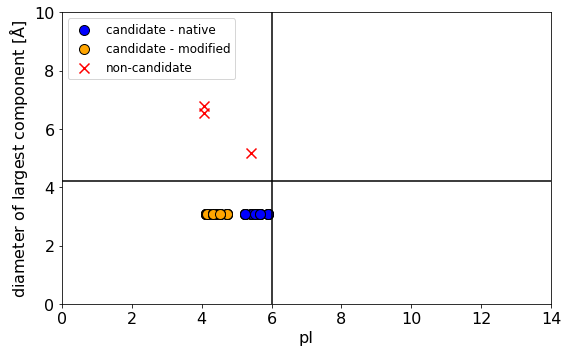

In [176]:
fig, ax = plt.subplots(figsize=(8,5))
# iterate over reaction system files
for rsf in react_syst_files:
    _rsf = rsf.replace(output_dir+'sRS-', '').replace('.pkl', '')
    EC_, DB, DB_ID = _rsf.split('-')
    EC = EC_.replace("_", ".")
    rs = rxn_syst.reaction(EC, DB, DB_ID)
    if os.path.isfile(output_dir+rs.pkl) is False:
        print('you have not collected all reaction systems.')
        print('Exitting.')
        import sys
        sys.exit()
    # load in rxn system
    rs = rs.load_object(output_dir+rs.pkl, verbose=False)
    if rs.skip_rxn is True:
        continue
        
    if rs.seed_MOF is None:
        continue
    
    if rs.all_fit is True and rs.seed_MOF is True:
        M = 'o'
        if rs.req_mod is not None:
            C = 'orange'
        else:
            C = 'b'
        E = 'k'
    else:
        M = 'x'
        C = 'r'
        E = 'k'
        
    ax.scatter(rs.pI,
               rs.max_comp_size, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
# decoy legend
ax.scatter(-100, 100,
           c='b', 
           edgecolors=E,
           marker='o', 
           alpha=1.0,
           s=100,
           label='candidate - native')
ax.scatter(-100, 100,
           c='orange',
           edgecolors=E,
           marker='o',
           alpha=1,
           s=100,
           label='candidate - modified')
ax.scatter(-100, 100,
           c='r',
           edgecolors=E,
           marker='x',
           alpha=1,
           s=100,
           label='non-candidate')

ax.legend(loc=2, fontsize=12)

ax.axhline(y=threshold, c='k')
ax.axvline(x=param_dict['cutoff_pi'], c='k')
define_plot_variables(ax,
                      title='',
                      xtitle='pI',
                      ytitle='diameter of largest component [$\mathrm{\AA}$]',
                      xlim=(0, 14),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"size_vs_pI.pdf", dpi=720,
            bbox_inches='tight')

### Plot # of reactions vs threshold value

In [177]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


In [178]:
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')

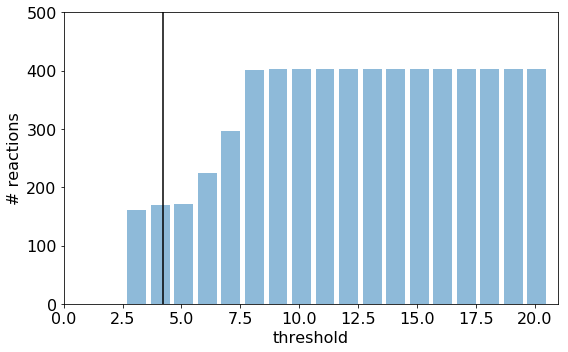

In [181]:
fig, ax = plt.subplots(figsize=(8,5))
max_sizes = []
# iterate over reaction system files
count = 0
for rsf in react_syst_files:
    _rsf = rsf.replace(output_dir+'sRS-', '').replace('.pkl', '')
    EC_, DB, DB_ID = _rsf.split('-')
    EC = EC_.replace("_", ".")
    rs = rxn_syst.reaction(EC, DB, DB_ID)
    if os.path.isfile(output_dir+rs.pkl) is False:
        print('you have not collected all reaction systems.')
        print('Exitting.')
        import sys
        sys.exit()
    # load in rxn system
    rs = rs.load_object(output_dir+rs.pkl, verbose=False)
    if rs.skip_rxn is True:
        continue

    try:
        if rs.max_comp_size > 0:
            max_sizes.append(rs.max_comp_size)
    except AttributeError:
        pass
    
max_sizes = np.asarray(max_sizes)
counts = []
threshs = np.arange(0.1, 21, 1)
for thr in threshs:
    count_above = len(max_sizes[max_sizes < thr])
    counts.append(count_above)
    
ax.bar(threshs, counts, align='center', alpha=0.5)

ax.axvline(x=threshold, c='k')

define_plot_variables(ax,
                      title='',
                      xtitle='threshold',
                      ytitle='# reactions',
                      xlim=(0, 21),
                      ylim=(0, 500))
fig.tight_layout()
fig.savefig(output_dir+"size_vs_threshold.pdf", dpi=720,
            bbox_inches='tight')

### Categorize all molecules in output file

In [182]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticklabels(['diffuses', 'does not diffuse'])
    ax.set_xticks([0.25, 0.75])

In [183]:
molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)

In [187]:
row

name                                                     NAD(+)
iupac_name                                                  NaN
DB                                                         BKMS
DB_ID                                                     15846
SMILE         NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...
role                                                    product
min_diam                                                      0
mid_diam                                                      0
max_diam                                                      0
ratio_1                                                       0
ratio_2                                                       0
Name: 135, dtype: object

unique molecule that fits: H2O - DB: SABIO - ID: 40
unique molecule that fits: O2 - DB: SABIO - ID: 1264
unique molecule that fits: H2O2 - DB: SABIO - ID: 1909
unique molecule that fits: NH3 - DB: SABIO - ID: 1268
unique molecule that fits: CO2 - DB: SABIO - ID: 1266
unique molecule that fits: methanol - DB: BKMS - ID: 17790
unique molecule that fits: formaldehyde - DB: BKMS - ID: 16842
unique molecule that fits: hydron - DB: BKMS - ID: 15378
unique molecule that fits: Ca2+ - DB: SABIO - ID: 1289
unique molecule that fits: CN- - DB: SABIO - ID: 2269
unique molecule that fits: dioxygen - DB: BKMS - ID: 15379
unique molecule that fits: monocarboxylic acid anion - DB: KEGG - ID: 35757
unique molecule that fits: fatty acid - DB: KEGG - ID: 35366
unique molecule that fits: superoxide - DB: BKMS - ID: 18421
unique molecule that fits: bromide - DB: BKMS - ID: 15858
unique molecule that fits: hypobromous acid - DB: BKMS - ID: 29249
unique molecule that fits: N-acylammonia - DB: BKMS - ID: 8362

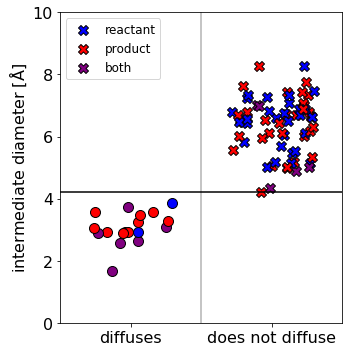

In [189]:
dx = 0.15
fig, ax = plt.subplots(figsize=(5,5))
for idx, row in molecule_output.iterrows():
    mid_diam = row['mid_diam']
    if mid_diam == 0:
        continue
    if mid_diam <= threshold:
        M = 'o'
        E = 'k'
        D = 0.25
        print('unique molecule that fits:', row['name'], 
              '- DB:', row['DB'], '- ID:', row['DB_ID'])
    else:
        M = 'X'
        E = 'k'
        D = 0.75
    
    # set colour based on role
    if row['role'] == 'reactant':
        C = 'b'
    elif row['role'] == 'product':
        C = 'r'
    elif row['role'] == 'both':
        C = 'purple'
    
    ax.scatter(D+(dx*(np.random.random() - 0.5) * 2),
               mid_diam, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
# decoy legend
ax.scatter(-100, 100,
           c='b', 
           edgecolors=E, marker=M, alpha=1.0,
           s=100,
           label='reactant')
ax.scatter(-100, 100,
           c='r', 
           edgecolors=E, marker=M, alpha=1.0,
           s=100,
           label='product')
ax.scatter(-100, 100,
           c='purple', 
           edgecolors=E, marker=M, alpha=1.0,
           s=100,
           label='both')

ax.legend(loc=2, fontsize=12)

ax.axhline(y=threshold, c='k')
ax.axvline(x=0.5, c='k', alpha=0.3)
define_plot_variables(ax,
                      title='',
                      xtitle='',
                      ytitle='intermediate diameter [$\mathrm{\AA}$]',
                      xlim=(0, 1),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"categorical.pdf", dpi=720,
            bbox_inches='tight')

In [192]:
molecule_output[molecule_output['name'] == 'monocarboxylic acid anion']['SMILE']

67    *C(=O)[O-]
Name: SMILE, dtype: object

In [201]:
a = Chem.MolFromSmiles('C')

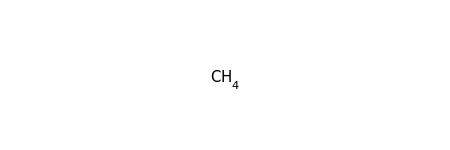

In [202]:
a

### print all reactions that fit

# Archive Code

## Brenda Attempts

In [12]:
from IPython.display import clear_output

In [15]:
print('Screen all Enzymes in EC Classes using BRENDA data')
count_done = 0
total_start_time = time.time()
for EC_file in database_names:
    if EC_file != '/home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_7__BRENDA_sequences.fasta':
        continue
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    print('-----------------------------------------------')
    print('doing:', EC_file)
    file_mod = EC_file.replace(".fasta", "_mod.fasta")
    EC_pi_data = pi_data[pi_data['fasta_file'] == file_mod]
    # only keep those that pass the pI test
    pi_passed_data = EC_pi_data[EC_pi_data['pi'] < param_dict['cutoff_pi']]
    print('--- ', 
          len(pi_passed_data), 'proteins out of', len(EC_pi_data), 
          'remain, OR', int(len(pi_passed_data)/len(EC_pi_data)*100),
          "% ---")
    EC_no = list(set(EC_pi_data['EC.code']))[0].replace(' ', '').replace(".", "_")
    print('EC:', EC_no.replace("_", "."))
    br_datafile = 'brenda_download_'+EC_no+'.txt'
    # convert br_datafile into dictionary
    br_symbols, br_data = brenda_IO.get_brenda_dict(param_dict['BRENDA_DB_loc']+br_datafile)
    # from here is quite bio-min assay literature specific
    # - although the code can be reused
    # get species of interest from known EC records
    ## when generalizing - we want to remove this for loop
    species_of_interest = EC_set[EC_no.replace('_', '.')]
    for spec in species_of_interest:
        print('species:', spec)
        spec_in_seq, spec_in_br = brenda_IO.is_species_reported(spec, 
                                                                EC_pi_data, 
                                                                br_data, 
                                                                verbose=True)
        # get protein numbers associated with species
        PR_of_int = []
        for i in sorted(br_data['PR']):
            if spec in i.lower():
                # this assumes that the first item of each line is always "#"
                PR_info = i.split("#")[1]            
                if PR_info not in PR_of_int:
                    PR_of_int.append(PR_info)
        print('when you want to go species unspecific you set PR_of_int to None and loop over all.')
        # get reaction systems from BRENDA
        prop_of_int = 'SP'
        list_of_int = br_data[prop_of_int]
        EC_prop_PR_codes = brenda_IO.get_prop_PR_codes(list_of_int)
        value_of_int = {}
        ## when generalizing - we want to remove this for loop
        for PR in PR_of_int:
            if PR in set([j for i in EC_prop_PR_codes.values() for j in i ]):
                print('protein code:', PR, 'has', prop_of_int, 'in BRENDA')
            else:
                print('protein code:', PR, 'does not have', prop, 'in BRENDA')
            values = [list_of_int[i]
                      for i in EC_prop_PR_codes.keys() if PR in EC_prop_PR_codes[i]]
            count = 0
            # iterate over all lines of BRENDA file with PR in SP initial
            for val in values:
                #if '3-(4-hydroxyphenyl)propanoic' not in val:
                #    continue
                print(val)
                print('############################')
                # split val into sections and remove preceding sections to avoid
                # confusion
                PR_sect = val.split("# ")[0]+"# "
                val = val.replace(PR_sect, '')
                rxn_sect = val.split(" (")[0].split(" <")[0]
                val = val.replace(rxn_sect, '')
                meta_sect = val
                # output dictionary
                reaction_system = brenda_IO.Reaction_system(EC_no, prop_of_int, PR, str(count))
                # get all PR associated with rxn system
                # strip value of anything in the first pair of "#" >> as PR codes
                t_assoc_PR = PR_sect.split("#")[1].split(',')
                # check for new lines and split string into list
                reaction_system.assoc_PR = brenda_IO.check_new_lines_and_split(t_assoc_PR)
                # strip value of anything in "(" and ")" >> as meta
                reaction_system.meta = meta_sect
                # split meta info into:
                # references 
                # references for an entry in BRENDA are within "<" and ">"
                t_assoc_refs = val.split(" <")[-1]
                t_assoc_refs = t_assoc_refs.split(">")[0].split(',')
                reaction_system.assoc_refs = brenda_IO.check_new_lines_and_split(t_assoc_refs)
                # reversible?
                # for the "SP" entries - a 'r' enclosed in "{" and "}"
                # implies reversible
                if '{r}' in reaction_system.meta:
                    reaction_system.reversible = True
                # reaction catalysed and reaction type
                reaction_system.extract_general_rxn_info(br_data)

                # make into function -- extract_reactants_products
                # get reactants as before '=' and products as after
                react, prod = rxn_sect.split("=")
                # separate react and prod into molecules by "+"
                r_mol = react.split("+")
                p_mol = prod.split("+")
                # remove preceding and succeeding white space from all molecule names
                r_mol = [i.lstrip().rstrip() for i in r_mol]
                p_mol = [i.lstrip().rstrip() for i in p_mol]
                #####

                # add flags to reaction system for informaton also available in BRENDA
                # no. subunits
                reaction_system.extract_subunit_info(br_data, PR)
                # post translational mods
                reaction_system.extract_PTM(br_data, PR)
                # cofactors
                reaction_system.extract_cofactor_info(br_data, PR)
                # activation cmpds?
                reaction_system.extract_activating_mol(br_data, PR)

                reaction_system.react_mol = r_mol
                reaction_system.prod_mol = p_mol
                
                reaction_system.print_rxn_system()
                input('done?')
                clear_output()
                # output reacion system to file
                # prefix + EC + property + PR code in BRENDA + count of associated files .pkl
                pickle_name = reaction_system.pickle_name
                # pickle reaction system object
                reaction_system.save_object(output_dir+pickle_name)
                count += 1

            break
            if len(values) > 0:
                value_of_int[PR] = values
    count_done += 1
print('--- finished %s EC classes in %s seconds ---' % (count_done, '{0:.2f}'.format(time.time() - total_start_time)))

#12,52# esculetin + H2O2 = ? (#52# demonstration, that esculetin is no
inhibitor, but a substrate of mushroom polyphenol oxidase (PPO) and
horseradish peroxidase (POD) <83>) <28,83>

############################
--------------------------
Reaction system in: RS-1_11_1_7-SP_52_2.pkl
Reaction Catalysed:
['2 phenolic donor + H2O2 = 2 phenoxyl radical of the donor + 2 H2O']
Reaction Type:
['redox reaction', 'oxidation', 'reduction', 'hydroxylation']
--------------------------
Reactants: esculetin + H2O2 -------->
Products: ?
Activating Molecules: melamine OR 2-aminothiazole
--------------------------
No. Sub units = ['?', 'monomer']
Reversible?: None
Co factors?: True
Cofactor Molecules: heme
Post Translational Mods?: ['glycoprotein']
--------------------------
Meta (in full):
 (#52# demonstration, that esculetin is no
inhibitor, but a substrate of mushroom polyphenol oxidase (PPO) and
horseradish peroxidase (POD) <83>) <28,83>

References: ['28', '83']
--------------------------


KeyboardInterrupt: 

In [9]:
file_t = '/home/atarzia/psp/sequence_db/bio_min_dataset/3_1_1_6__BRENDA_sequences_mod.fasta'
temp1 = pi_data[pi_data['fasta_file'] == file_t]
temp2 = temp1[temp1['species'] == ' Vibrio parahaemolyticus V-223/04 ']
print(temp2)

                                                fasta_file acc.code  \
1305091  /home/atarzia/psp/sequence_db/bio_min_dataset/...  Z2DBW5    
1305092  /home/atarzia/psp/sequence_db/bio_min_dataset/...  Z2DBW5    
1305123  /home/atarzia/psp/sequence_db/bio_min_dataset/...  Z2EP46    

                 organism    EC.code                             species  \
1305091   acetylesterase    3.1.1.6    Vibrio parahaemolyticus V-223/04    
1305092   acetylesterase    3.1.1.6    Vibrio parahaemolyticus V-223/04    
1305123   acetylesterase    3.1.1.6    Vibrio parahaemolyticus V-223/04    

            note    pi  modification  category  
1305091   TrEMBL  6.38             0         1  
1305092   TrEMBL  6.38             1         1  
1305123   TrEMBL  5.79             0         0  


In [10]:
temp1.loc[1305123]['species']

' Vibrio parahaemolyticus V-223/04 '

##  load in reaction system

In [38]:
# load in reaction system from pickle file
new_reaction_system = brenda_IO.Reaction_system.load_object(output_dir+pickle_name)

In [39]:
new_reaction_system.print_rxn_system()

--------------------------
Reaction system in: RS-1_11_1_7-SP_52_0.pkl
Reaction Catalysed:
['2 phenolic donor + H2O2 = 2 phenoxyl radical of the donor + 2 H2O']
Reaction Type:
['redox reaction', 'oxidation', 'reduction', 'hydroxylation']
--------------------------
Reactants: guaiacol + H2O2 -------->
Products: tetraguaiacol + H2O
Activating Molecules: melamine OR 2-aminothiazole
--------------------------
No. Sub units = ['?', 'monomer']
Reversible?: None
Co factors?: True
Cofactor Molecules: heme
Post Translational Mods?: ['glycoprotein']
--------------------------
Meta (in full):
(#64# 100% activity <80>; #83# 100% activity with guaiacol at 25 mM
<105>; #44# 74% activity compared to
2,2-azino-bis-(3-ethyl-6-benzothiazolinsulfonate) <82>; #82# shows high
efficiency of interaction with guaiacol at 25 mM <105>; #30# 100%
activity, high efficiency of interaction with guaiacol at 25 mM <105>;
#52# optimal concentrations of guaiacol and H2O2 are 0.5 mM and 0.3 mM,
respectively <139>)
<5,6,

## collect SMILES from common name from Brenda

### CHEMBL

In [43]:
available_resources = [resource for resource in dir(new_client) if not resource.startswith('_')]
print(available_resources)
print(len(available_resources))

# molecule handler
molecule = new_client.molecule
molecule.set_format('json')

# get molecule using unambiguous
m3 = molecule.get('CC(=O)Oc1ccccc1C(=O)O')

# batch queries
records3 = molecule.get(['CNC(=O)c1ccc(cc1)N(CC#C)Cc2ccc3nc(C)nc(O)c3c2',
            'Cc1cc2SC(C)(C)CC(C)(C)c2cc1\\N=C(/S)\\Nc3ccc(cc3)S(=O)(=O)N',
            'CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H]3CCCN3C(=O)C(CCCCN)CCCCN)C(C)(C)C)C(=O)O'])

['activity', 'assay', 'atc_class', 'binding_site', 'biotherapeutic', 'cell_line', 'chembl_id_lookup', 'compound_record', 'compound_structural_alert', 'description', 'document', 'document_similarity', 'document_term', 'drug', 'drug_indication', 'go_slim', 'image', 'mechanism', 'metabolism', 'molecule', 'molecule_form', 'official', 'organism', 'protein_class', 'similarity', 'source', 'substructure', 'target', 'target_component', 'target_prediction', 'target_relation', 'tissue', 'xref_source']
33


In [44]:
from chembl_webresource_client.new_client import new_client
molecule = new_client.molecule
res = molecule.search('vinylacetyl-CoA')  # 'viagra')
# guaiacol

In [45]:
print(res[0]['molecule_chembl_id'])
print(res[0]['molecule_structures']['canonical_smiles'])
print('there are', len(res), 'top search candidates:')
for i in range(len(res)):
    print('option:', i, 'name:', res[i]['pref_name'])
    print([res[i]['molecule_synonyms'][j]['synonyms'] for j in range(len(res[i]['molecule_synonyms']))])

TypeError: 'NoneType' object is not subscriptable

##  SABIO-RK
http://sabiork.h-its.org/layouts/content/docuRESTfulWeb/searchPython.gsp

In [3]:
output_dir = '/home/atarzia/psp/molecule_DBs/SABIO/'
# SABIO specific definitions and functions
db_dir = '/home/atarzia/psp/molecule_DBs/SABIO/'
mol_output_file = db_dir+'screening_output.csv'
threshold = 4.2

### get all entries per EC

In [4]:
# set EC 
EC = "1.11.1.7"
# get all SABIO entries
entries = SABIO_IO.get_entries_per_EC(EC)

67 matching entries found.


### Get all reaction systems (ONLINE) for all entries

In [ ]:
# iterate over entries
count = 0
for eID in entries:
    print('entry:', eID, ':', count, 'of', len(entries))
    # initialise reaction system object
    rxn_syst = SABIO_IO.SABIO_reaction(EC, eID)
    if os.path.isfile(output_dir+rxn_syst.pkl_name) is True:
        print('done')
        count += 1
        continue
    # get reaction ID
    rxn_syst.organism, rxn_syst.rID, rxn_syst.UniprotID = SABIO_IO.get_rxnID_from_eID(eID)
    # get reaction system
    rxn_syst.get_reaction_system()
    # rxn_syst.print_rxn_system()
    # append compound information
    for m in rxn_syst.components:
        m.get_cmpd_information()

    # pickle reaction system object to file
    # prefix (sRS for SABIO) + EC + EntryID .pkl
    rxn_syst.save_object(output_dir+rxn_syst.pkl_name)
    print('done')
    count += 1

### get all reaction systems that fit (OFFLINE)

In [6]:
molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)

In [7]:
react_syst_files = glob.glob(db_dir+'sRS-'+EC.replace('.', '_')+'-*.pkl')

In [ ]:
# iterate over reaction system files
for rsf in react_syst_files:
    eID = rsf.replace(db_dir+'sRS-'+EC.replace('.', '_')+'-', '').split('.')[0]
    print('-------------------------------------------')
    print('entry:', eID)
    # initialise reaction system object
    rxn_syst = SABIO_IO.SABIO_reaction(EC, eID)
    if os.path.isfile(output_dir+rxn_syst.pkl_name) is False:
        print('you have not collected all reaction systems.')
        print('Exitting.')
        import sys
        sys.exit()
    # load in rxn system
    rxn_syst = rxn_syst.load_object(output_dir+rxn_syst.pkl_name)
    # rxn_syst.print_rxn_system()
    # define reactants and products dict
    # name: (smile, DB, DB_ID, iupac_name, role)
    components_dict = {}
    
    # ignore any reactions with unknown components
    skip_rxn = False
    for m in rxn_syst.components:
        if m.mol is None:
            skip_rxn = True
            
    if skip_rxn is True:
        print('skipping reaction - it is incomplete or generic')
        continue
    for m in rxn_syst.components:
        smile = Chem.MolToSmiles(Chem.RemoveHs(m.mol))
        # note that for SABIO we do not have IUPAC names
        components_dict[m.name] = (smile, 'SABIO', m.cID, None, m.role)
            
    # calculate molecule size of all components
    # save to molecule output files
    molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
    DB_functions.get_molecule_diameters(components_dict,
                                        molecule_output=molecule_output,
                                        mol_output_file=mol_output_file, db_dir=db_dir,
                                        vdwScale=0.8, boxMargin=4.0, 
                                        spacing=0.6, N_conformers=10, MW_tresh=130)
    
    molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
    
    # get diameters (should alrady be calculated) 
    # of all components of reaction
    all_fit = rxn_syst.all_fit
    if all_fit is None:
        rxn_syst.check_all_fit(threshold, molecule_output)
        rxn_syst.save_object(output_dir+rxn_syst.pkl_name)
    elif all_fit is True:
        print('------------------------------------')
        rxn_syst.print_rxn_system
        print("This reaction should diffuse!")
        print('------------------------------------')

### get the pI of all sequences from UNIPROT of all reaction systems that fit

In [10]:
# get parameters for pI
param_dict = parameters.get_parameters()

In [11]:
molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)

In [12]:
react_syst_files = glob.glob(db_dir+'sRS-'+EC.replace('.', '_')+'-*.pkl')

In [ ]:
# iterate over reaction system files
for rsf in react_syst_files:
    eID = rsf.replace(db_dir+'sRS-'+EC.replace('.', '_')+'-', '').split('.')[0]
    print('-------------------------------------------')
    print('entry:', eID)
    # initialise reaction system object
    rxn_syst = SABIO_IO.SABIO_reaction(EC, eID)
    if os.path.isfile(output_dir+rxn_syst.pkl_name) is False:
        print('you have not collected all reaction systems.')
        print('Exitting.')
        import sys
        sys.exit()
    # load in rxn system
    rxn_syst = rxn_syst.load_object(output_dir+rxn_syst.pkl_name)

    # do all components fit?
    if rxn_syst.all_fit is not True:
        continue
    # pI already checked?
    if rxn_syst.seed_MOF is not None:
        continue
    if len(rxn_syst.UniprotID) > 0:
        sequence = Uniprot_IO.get_sequence(rxn_syst.UniprotID)
        rxn_syst = pi_fn.calculate_rxn_syst_pI(sequence, rxn_syst, param_dict=param_dict)
        rxn_syst.save_object(output_dir+rxn_syst.pkl_name)
        print('seed MOF?', rxn_syst.seed_MOF)
    else:
        rxn_syst.save_object(output_dir+rxn_syst.pkl_name)
        print('seed MOF?', rxn_syst.seed_MOF)

##  KEGG

In [5]:
output_dir = '/home/atarzia/psp/molecule_DBs/KEGG/'
# KEGG specific definitions and functions
db_dir = '/home/atarzia/psp/molecule_DBs/KEGG/'
mol_output_file = db_dir+'screening_output.csv'
threshold = 4.2

## get all reaction systems for each EC class from JSON file

In [105]:
import json
import requests

In [100]:
def get_EC_rxns_from_JSON(JSON_DB, EC):
    """Get reactions associated with EC number in KEGG.
    
    """
    EC_heir = [int(i) for i in EC.split('.')]
    for i in rxn_DB['children'][EC_heir[0]-1]['children']:
        for j in i['children']:
            for k in j['children']:
                EC_sub = k['name']
                if EC == EC_sub:
                    EC_rxn = k['children']
                    break
    return EC_rxn

In [73]:
rxn_DB_file = db_dir+'br08201.json'
with open(rxn_DB_file, 'r') as data_file:
     rxn_DB = json.load(data_file)


In [102]:
# set EC 
EC = "1.11.1.7"

# get EC rxns
EC_rxns = get_EC_rxns_from_JSON(rxn_DB, EC)

# get rxn IDs

### Get all reaction systems + their components (ONLINE) for all entries

In [130]:
for rxn in EC_rxns[1:]:
    string = rxn['name']
    print(string)
    # get KEGG rxn id
    K_Rid = string.split(' ')[0].rstrip()
    print(K_Rid)
    # get Reaction information from KEGG API
    URL = 'http://rest.kegg.jp/get/reaction:'+K_Rid
    request = requests.post(URL)
    request.raise_for_status()
    print(request.text)
    components = []
    # because of the formatting of KEGG text - this is trivial
    equations_string = request.text.split('EQUATION    ')[1].split('\n')[0].rstrip()
    print(equations_string)
    if '<=>' in equations_string:
        # implies it is reversible
        reactants, products = equations_string.split("<=>")
        print("reaction is reversible")
    else:
        reactants, products = equations_string.split("=")
    
    rc = ['C'+i.split('C')[1] for i in reactants.split("+")]
    pc = ['C'+i.split('C')[1] for i in products.split("+")]
    print(rc, pc)
    
    # ignore stoichiometry at the moment
    for i in rc:
        components.append((i, 'reactant'))
    for i in pc:
        components.append((i, 'product'))
    print(components)
    
    for comp in components:
        print(comp)
        # get compound information from KEGG API
        # just convert to CHEBI ID
        URL = 'http://rest.kegg.jp/conv/chebi/compound:'+comp[0]
        request = requests.post(URL)
        request.raise_for_status()
        print(request.text)
        # get CHEBI ID
        # because of the formatting of KEGG text - this is trivial
        if 'chebi' in request.text:
            CHEBI_ID = request.text.split('chebi:')[1].split('\n')[0].rstrip()
            print(CHEBI_ID)
        else:
            print('CHEBI ID not available - skipping')

    
    break

R00602  Methanol + Hydrogen peroxide  Formaldehyde + 2 H2O
R00602
ENTRY       R00602                      Reaction
NAME        methanol:hydrogen-peroxide oxidoreductase
DEFINITION  Methanol + Hydrogen peroxide <=> Formaldehyde + 2 H2O
EQUATION    C00132 + C00027 <=> C00067 + 2 C00001
RCLASS      RC00034  C00067_C00132
ENZYME      1.11.1.6        1.11.1.7        1.11.1.21
PATHWAY     rn01100  Metabolic pathways
            rn01120  Microbial metabolism in diverse environments
ORTHOLOGY   K00430  peroxidase [EC:1.11.1.7]
            K03781  catalase [EC:1.11.1.6]
            K03782  catalase-peroxidase [EC:1.11.1.21]
            K11188  peroxiredoxin 6, 1-Cys peroxiredoxin [EC:1.11.1.7 1.11.1.15 3.1.1.-]
DBLINKS     RHEA: 30694
///

C00132 + C00027 <=> C00067 + 2 C00001
reaction is reversible
['C00132 ', 'C00027 '] ['C00067 ', 'C00001']
[('C00132 ', 'reactant'), ('C00027 ', 'reactant'), ('C00067 ', 'product'), ('C00001', 'product')]
('C00132 ', 'reactant')
cpd:C00132	chebi:17790

17790
(

In [11]:
URL = 'http://rest.kegg.jp/find/enzyme/1.1.1.1'
URL = 'http://rest.kegg.jp/get/ec:1.1.1.1'
request = requests.post(URL)
request.raise_for_status()
print(request.text)

ENTRY       EC 1.1.1.1                  Enzyme
NAME        alcohol dehydrogenase;
            aldehyde reductase;
            ADH;
            alcohol dehydrogenase (NAD);
            aliphatic alcohol dehydrogenase;
            ethanol dehydrogenase;
            NAD-dependent alcohol dehydrogenase;
            NAD-specific aromatic alcohol dehydrogenase;
            NADH-alcohol dehydrogenase;
            NADH-aldehyde dehydrogenase;
            primary alcohol dehydrogenase;
            yeast alcohol dehydrogenase
CLASS       Oxidoreductases;
            Acting on the CH-OH group of donors;
            With NAD+ or NADP+ as acceptor
SYSNAME     alcohol:NAD+ oxidoreductase
REACTION    (1) a primary alcohol + NAD+ = an aldehyde + NADH + H+ [RN:R00623];
            (2) a secondary alcohol + NAD+ = a ketone + NADH + H+ [RN:R00624]
ALL_REAC    R00623 > R00754 R02124 R02878 R04805 R04880 R05233 R05234 R06917 R06927 R08281 R08306 R08557 R08558 R10783;
            R00624 > R08310;
          

### get all entries per EC

In [16]:
# set EC 
EC = "1.11.1.7"
# get KEGG entry for EC class
URL = 'http://rest.kegg.jp/get/ec:'+EC
enzyme_r = requests.post(URL)
enzyme_r.raise_for_status()
enzyme = enzyme_r.text

### get all reaction IDs from KEGG
- if a line ends in ';' => the section continues to next line

In [36]:
enzyme.split(';\n            ')

['ENTRY       EC 1.11.1.7                 Enzyme\nNAME        peroxidase',
 'lactoperoxidase',
 'guaiacol peroxidase',
 'plant peroxidase',
 'Japanese radish peroxidase',
 'horseradish peroxidase (HRP)',
 'soybean peroxidase (SBP)',
 'extensin peroxidase',
 'heme peroxidase',
 'oxyperoxidase',
 'protoheme peroxidase',
 'pyrocatechol peroxidase',
 'scopoletin peroxidase',
 'Coprinus cinereus peroxidase',
 'Arthromyces ramosus peroxidase\nCLASS       Oxidoreductases',
 'Acting on a peroxide as acceptor',
 'Peroxidases\nSYSNAME     phenolic donor:hydrogen-peroxide oxidoreductase\nREACTION    2 phenolic donor + H2O2 = 2 phenoxyl radical of the donor + 2 H2O [RN:R03532]\nALL_REAC    R03532 > R00602',
 '(other) R02596 R03919 R04007 R07443\nSUBSTRATE   phenolic donor',
 'H2O2 [CPD:C00027]\nPRODUCT     phenoxyl radical of the donor',
 "H2O [CPD:C00001]\nCOMMENT     Heme proteins with histidine as proximal ligand. The iron in the resting enzyme is Fe(III). They also peroxidize non-phenolic subs

In [37]:
# produce a dictionary of target sections from the text
rxn_saved_lines = []
gene_saved_lines = []
rxn_section_on = 1  # switch between saving and not saving
gene_section_on = 1  # switch between saving and not saving
for line in enzyme.split('\n'):
    if len(line) == 0:
        continue
    if 'ALL_REAC' in line:
        print(line)
        rxn_section_on = 0
    elif line[0] != ' ' and rxn_section_on == 0:
        print(line.split(' '))
        # implies new section
        # section = line.split(' ')[0]
        rxn_section_on = 1
    if rxn_section_on == 0:
        rxn_saved_lines.append(line)
    if 'GENES' in line:
        print(line)
        gene_section_on = 0
    elif line[0] != ' ' and gene_section_on == 0:
        print(line.split(' '))
        # implies new section
        # section = line.split(' ')[0]
        gene_section_on = 1
    if gene_section_on == 0:
        gene_saved_lines.append(line)

ALL_REAC    R03532 > R00602;
['SUBSTRATE', '', '', 'phenolic', 'donor;']
GENES       HSA: 137902(PXDNL) 4025(LPO) 7837(PXDN) 8288(EPX) 9588(PRDX6)
['DBLINKS', '', '', '', '', 'ExplorEnz', '-', 'The', 'Enzyme', 'Database:', '1.11.1.7']


In [38]:
rxn_saved_lines

['ALL_REAC    R03532 > R00602;',
 '            (other) R02596 R03919 R04007 R07443']

In [39]:
gene_saved_lines

['GENES       HSA: 137902(PXDNL) 4025(LPO) 7837(PXDN) 8288(EPX) 9588(PRDX6)',
 '            PTR: 458999(PXDN) 464171(PXDNL) 468420(EPX) 468421(LPO) 469589(PRDX6) 738041',
 '            PPS: 100970837(PXDN) 100971181(PRDX6) 100976829(PXDNL) 100989391 100993002(LPO) 100993817(EPX)',
 '            GGO: 101123795(PXDN) 101133073(PXDNL) 101134324(EPX) 101139252(PRDX6) 109025135',
 '            PON: 100173342(PRDX6) 100435161(PXDNL) 100437241(EPX) 100455727(PXDN) 100462313(LPO)',
 '            NLE: 100584100(PXDNL) 100596896(EPX) 100600005(PRDX6) 100600453(PXDN) 100605812(LPO)',
 '            MCC: 706486(PRDX6) 709655(EPX) 709848(LPO) 717095(PXDNL) 721654(PXDN)',
 '            MCF: 102127694(EPX) 102128095(LPO) 102136886(PXDN)',
 '            CSAB: 103220944(PXDN) 103230573(PRDX6) 103236777(PXDNL) 103242853(LPO) 103242855(EPX)',
 '            RRO: 104665513(PRDX6) 104666977(PXDNL) 104669822(EPX) 104669825(LPO) 104680248(PXDN)',
 '            RBB: 108520784(PXDN) 108521649(EPX) 108521656(LPO)

## BKMS
### Using ChEBI

In [32]:
bkms_dir = '/home/atarzia/psp/molecule_DBs/BKMS_react/'

In [33]:
bkms_data = BKMS_IO.init_BKMS(bkms_dir)

BKMS Stats:
The table contains actual data of BRENDA (release 2018.2, only
reactions with naturally occuring substrates), MetaCyc (version
21.5), SABIO-RK (02/05/2018) and KEGG data, downloaded 23/04/2012.
(Downloading more recent KEGG data cannot be offered because a
KEGG license agreement would be necessary.)
----------------
independant EC No.: 6976
independant Rxns: 31740
independant non-generic Rxns: 26103


In [37]:
bkms_data[bkms_data['EC'] == '1.11.1.7'].iloc[0]

ID                                                              8220
EC                                                          1.11.1.7
Rec. Name                                                 peroxidase
rxn                             H2O2 + methanol = formaldehyde + H2O
RID_Brenda                                                  BS373379
RID_KEGG                                                      R00602
RID_metacyc                                                RXN-14189
RID_SABIO                                                        NaN
Brenda_pathway_name                                              NaN
KEGG_pathway_ID                                              rn01120
KEGG_pathway_name       Microbial metabolism in diverse environments
metacyc_pathway_id                                               NaN
metacyc_pathway_name                                             NaN
stoich_check                                                     NaN
missing substrate                 

In [4]:
# chebi specific definitions and functions
db_dir = '/home/atarzia/psp/molecule_DBs/chebi/'
compounds_file = db_dir+'compounds.tsv'
names_file = db_dir+'names.tsv'
structures_file = db_dir+'structures.csv'
mol_output_file = db_dir+'screening_output.csv'

In [5]:
molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)

## run the calculation of molecule diameters
### probably can do once - upon completion of the code.

In [6]:
for idx, row in bkms_data.iterrows():
    # target EC No. of interest
    if row['EC'] != '1.11.1.7':
        continue
    # ignore those with 'generic' in remark
    if 'generic' in row['remark']:
        continue
    # ignore those with missing substrates
    if pd.isna(row['missing substrate']) is False:
        continue
    print(row['ID'], ":", row['EC'], ":", row['Rec. Name'])
    print("reaction:", row['rxn'])
    if '<=>' in row['rxn']:
        # implies it is reversible
        reactants, products = row['rxn'].split("<=>")
        print("reaction is reversible")
    else:
        reactants, products = row['rxn'].split("=")
    reactants = reactants.split("+")
    products = products.split("+")
    # remove white space on the left and right ends
    reactants = [i.lstrip().rstrip() for i in reactants]
    products = [i.lstrip().rstrip() for i in products]

    # check if any of the reactants or products should be skipped
    if BKMS_IO.skip_names(reactants+products) is True:
        # skip whole reaction if one component has skipped name
        continue
    
    # check if the reactants or products contain the term radical
    # here we will assume that structurally the non radical can
    # represent the radical - and the radical component is ignored.
    rad_to_remove = BKMS_IO.check_for_radicals(reactants+products)
    if len(rad_to_remove) > 0:
        reactants = [i for i in reactants if i not in rad_to_remove]
        products = [i for i in products if i not in rad_to_remove]
    
    # get SMILES of reactants and products
    reactants_dict = BKMS_IO.get_SMILES_for_molecule_list(mol_list=reactants, DBs='CHEBI')
    products_dict = BKMS_IO.get_SMILES_for_molecule_list(mol_list=products, DBs='CHEBI')
    print(reactants_dict)
    print(products_dict)
    
    # calculate molecule size of all reactants
    # save to molecule output files
    molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
    DB_functions.get_molecule_diameters(reactants_dict, role='reactant',
                                        molecule_output=molecule_output,
                                        mol_output_file=mol_output_file, db_dir=db_dir,
                                        vdwScale=0.8, boxMargin=4.0, 
                                        spacing=0.6, N_conformers=10, MW_tresh=130)
    
    # calculate molecule size of all products
    # save to molecule output files
    molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
    DB_functions.get_molecule_diameters(products_dict, role='product',
                                        molecule_output=molecule_output, 
                                        mol_output_file=mol_output_file, db_dir=db_dir,
                                        vdwScale=0.8, boxMargin=4.0, 
                                        spacing=0.6, N_conformers=10, MW_tresh=130)
    
    molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
    # break
    
    

8220 : 1.11.1.7 : peroxidase
reaction: H2O2 + methanol = formaldehyde + H2O
H2O2
methanol
formaldehyde
H2O
{'H2O2': ('OO', 'CHEBI', '16240', 'hydrogen peroxide'), 'methanol': ('CO', 'CHEBI', '17790', 'methanol')}
{'formaldehyde': ('C=O', 'CHEBI', '16842', 'formaldehyde'), 'H2O': ('O', 'CHEBI', '15377', 'water')}
H2O2 ('OO', 'CHEBI', '16240', 'hydrogen peroxide')
methanol ('CO', 'CHEBI', '17790', 'methanol')
formaldehyde ('C=O', 'CHEBI', '16842', 'formaldehyde')
H2O ('O', 'CHEBI', '15377', 'water')
11029 : 1.11.1.7 : peroxidase
reaction: ascorbate + H2O2 = dehydroascorbate + H2O
ascorbate
molecule does not have recorded structure in DB
need to search another DB
H2O2
dehydroascorbate
H2O
{'ascorbate': ('-', 'CHEBI', '22651', 'ascorbate'), 'H2O2': ('OO', 'CHEBI', '16240', 'hydrogen peroxide')}
{'dehydroascorbate': ('O=C1OC(C(O)CO)C(=O)C1=O', 'CHEBI', '17242', 'dehydroascorbic acid'), 'H2O': ('O', 'CHEBI', '15377', 'water')}
ascorbate ('-', 'CHEBI', '22651', 'ascorbate')
H2O2 ('OO', 'CHEBI

In [7]:
molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)

In [8]:
molecule_output

,EC,name,iupac_name,DB,DB_ID,SMILE,role,min_diam,mid_diam,max_diam,ratio_1,ratio_2
0,1.11.1.7,H2O2,hydrogen peroxide,CHEBI,16240,OO,reactant,2.986807,3.118057,4.138026,0.100971,0.984063
1,1.11.1.7,methanol,methanol,CHEBI,17790,CO,reactant,3.407378,3.713598,4.787879,0.200172,0.961093
2,1.11.1.7,formaldehyde,formaldehyde,CHEBI,16842,C=O,product,2.810116,3.622782,4.543777,0.119605,0.880395
3,1.11.1.7,H2O,water,CHEBI,15377,O,product,2.491793,2.586459,3.747859,0.347358,0.652642
4,1.11.1.7,ascorbate,ascorbate,CHEBI,22651,-,reactant,0.000000,0.000000,0.000000,0.000000,0.000000
5,1.11.1.7,dehydroascorbate,dehydroascorbic acid,CHEBI,17242,O=C1OC(C(O)CO)C(=O)C1=O,product,4.829036,6.606758,9.655065,0.349458,0.714354
6,1.11.1.7,baicalein,baicalein,CHEBI,2979,O=c1cc(-c2ccccc2)oc2cc(O)c(O)c(O)c12,reactant,3.517921,9.057608,14.975799,0.182635,0.817365
7,1.11.1.7,luteolin 7-O-beta-D-diglucuronide,luteolin 7-O-[(beta-D-glucosyluronic acid)-(1-...,CHEBI,16559,O=C(O)[C@H]1O[C@@H](Oc2ccc3c(=O)cc(-c4ccc(O)c(...,reactant,8.278448,14.367061,19.895054,0.330569,0.795048
8,1.11.1.7,coniferyl alcohol,coniferol,CHEBI,17745,COc1cc(/C=C/CO)ccc1O,reactant,4.405513,8.579285,12.875207,0.189698,0.836250
9,1.11.1.7,betanidin,betanidin,CHEBI,3079,O=C(O)C1=C/C(=C/C=[N+]2/c3cc(O)c(O)cc3C[C@H]2C...,reactant,7.378211,10.945206,16.896386,0.237984,0.830105


### Categorize reaction pairs in a given EC no.

In [12]:
molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
threshold = 4.2

In [35]:
for idx, row in bkms_data.iterrows():
    # target EC No. of interest
    if row['EC'] != '1.11.1.7':
        continue
    # ignore those with 'generic' in remark
    if 'generic' in row['remark']:
        continue
    # ignore those with missing substrates
    if pd.isna(row['missing substrate']) is False:
        continue
    if '<=>' in row['rxn']:
        # implies it is reversible
        reactants, products = row['rxn'].split("<=>")
        print("reaction is reversible")
    else:
        reactants, products = row['rxn'].split("=")
    reactants = reactants.split("+")
    products = products.split("+")
    # remove white space on the left and right ends
    reactants = [i.lstrip().rstrip() for i in reactants]
    products = [i.lstrip().rstrip() for i in products]

    print(reactants)
    print(products)
    
    # get diameters (should alrady be calculated) 
    # of all components of reaction
    all_fit = True
    for r in reactants:
        # is molecule in molecule_output?
        if r in list(molecule_output['name']):
            r_diam = float(molecule_output[molecule_output['name'] == r]['mid_diam'])
            if r_diam > threshold or r_diam == 0:
                all_fit = False
                break
        else:
            # molecule not in output - assume it wasn't in database
            # dont report!
            all_fit = False
            break
            
        
    for p in products:
        # is molecule in molecule_output?
        if p in list(molecule_output['name']):
            p_diam = float(molecule_output[molecule_output['name'] == p]['mid_diam'])
            if p_diam > threshold or p_diam == 0:
                all_fit = False
                break
        else:
            # molecule not in output - assume it wasn't in database
            # dont report!
            all_fit = False
            break
            
    if all_fit is True:
        print('------------------------------------')
        print(row['ID'], ":", row['EC'], ":", row['Rec. Name'])
        print("reaction:", row['rxn'])
        print("This reaction should diffuse!")
        print('------------------------------------')
  

['H2O2', 'methanol']
['formaldehyde', 'H2O']
------------------------------------
8220 : 1.11.1.7 : peroxidase
reaction: H2O2 + methanol = formaldehyde + H2O
This reaction should diffuse!
------------------------------------
['ascorbate', 'H2O2']
['dehydroascorbate', 'H2O']
reaction is reversible
['Sinapyl alcohol']
['Syringyl lignin']
reaction is reversible
['4-Coumaryl alcohol']
['p-Hydroxyphenyl lignin']
['baicalein', 'hydrogen peroxide']
['6,7-dehydrobaicalein', 'H2O']
['luteolin 7-O-beta-D-diglucuronide', 'hydrogen peroxide']
['radical of luteolin-7-O-diglucuronide', 'H2O']
['coniferyl alcohol', 'hydrogen peroxide']
['coniferyl alcohol radical', 'H2O']
['betanidin', 'hydrogen peroxide']
['betanidin quinone', 'H2O']
['Br-', 'H2O2']
['hypobromous acid', 'H2O']
------------------------------------
71748 : 1.11.1.7 : peroxidase
reaction: Br- + H2O2 = hypobromous acid + H2O
This reaction should diffuse!
------------------------------------


## From reaction system data sets - determine reactions that can diffuse through